# cisTopic on 10X 5k PBMCs dataset

cisTopic is an R/Bioconductor package for the simulataneous identification of cis-regulatory topics and cell states from single cell epigenomics data. cisTopic relies on an algorithm called Latent Dirichlet Allocation (LDA), a robust Bayesian method used in text mining to group documents addressing similar topics and related words into topics. Interestingly, this model has a series of assumptions that are fulfilled in single-cell epigenomics data, such as non-ordered features (‘bag of words’) and the allowance of overlapping topics (i.e. a regulatory region can be co-accessible with different other regions depending on the context, namely, the cell type or state).

<img src="cistopic.png" width="1000"/>

In this tutorial, we will use a publicly available 10X dataset on peripheral blood mononuclear cells (PBMCs), consisting of scATAC-seq data from 5335 cells. This data has been pre-processed using cellRanger to provide a **count matrix** where *rows* correspond to cell barcodes and *columns* correspond to ATAC-seq peak genomic regions. The count inside this sparse matrix correspond to the number of non-duplicated fragment present in each cell within each genomic region. In addition cellRanger provide a **metrics.csv** file, summarising *quality-check* measures on a per-cell basis. Importantly, this file include information on which cell barcodes have been considered as *real* cell to creat the count matrix.

The analysis of this dataset will be decomposed into 5 parts :
1. running the LDA algorithm on the raw count data
2. analysing the cell-topic contribution matrix
3. analysing the region-topic contribution matrix
4. analysisng the region-cell predicitive matrix
5. export to loom file

<img src="cistopic_ws.001.png" width="700"/>


## 1. Preparing working environment

First, we will move to the correct work directory and load the necessary R libraries.

In [2]:
# set working directory
setwd("/tmp/")

# load libraries 
library(cisTopic)
library(Rtsne)
library(umap)
library(fastcluster)
library(grid)
library(plotly)
library(ggplot2)
library(scatterplot3d)
library(ComplexHeatmap)
library(repr)
library(TxDb.Hsapiens.UCSC.hg19.knownGene)
library(fitdistrplus)
library(MASS)
library(plyr)
library(AUCell)
library(SCopeLoomR)

# Change plot size to 14 x 8, adjust if necessary
options(repr.plot.width=14, repr.plot.height=8)

Now that we have the tools loaded, we will load the PBMC dataset into cisTopic by providing the path to the following files :
- the count matrix
- the metrics csv file

Note that you can also create a cisTopic object from an alignement file (BAM or fragment) and potential regulatory regions. In this case cisTopic will create the count matrix when loading the data.

In [5]:
pathTo10X <- '/genomic/ws_cell_dynamics/TP-SingleCellTranscriptomics/'
metrics <- paste0(pathTo10X, 'atac_v1_pbmc_5k_singlecell.csv')
matrix <- paste0(pathTo10X, 'filtered_peak_bc_matrix')
cisTopicObject <- createcisTopicObjectFrom10Xmatrix(matrix, metrics, project.name='5kPBMCs')

[1] "Creating cisTopic object..."


We can have a look at the object structure :

In [6]:
cisTopicObject

An object of class cisTopic in project 5kPBMCs 
 97200 regions across 5335 samples.

In [7]:
str(cisTopicObject, max.level = 2)

Formal class 'cisTopic' [package "cisTopic"] with 24 slots
  ..@ count.matrix            :Formal class 'dgTMatrix' [package "Matrix"] with 6 slots
  ..@ binary.count.matrix     :Formal class 'dgCMatrix' [package "Matrix"] with 6 slots
  ..@ is.acc                  : num 1
  ..@ models                  : list()
  ..@ selected.model          : NULL
  ..@ log.lik                 :'data.frame':	0 obs. of  0 variables
Formal class 'data.frame' [package "methods"] with 4 slots
  ..@ dr                      : list()
  ..@ calc.params             :List of 1
  ..@ cell.names              : chr [1:5335] "AAACGAAAGCGCAATG-1" "AAACGAAAGGGTATCG-1" "AAACGAAAGTAACATG-1" "AAACGAAAGTTACACC-1" ...
  ..@ cell.data               :'data.frame':	5335 obs. of  18 variables:
  ..@ region.names            : chr [1:97200] "chr1:10244-10510" "chr1:237575-237942" "chr1:565098-565554" "chr1:569172-569645" ...
  ..@ region.ranges           :Formal class 'GRanges' [package "GenomicRanges"] with 7 slots
  ..@ region.

## 2. Building the models

The next step in the cisTopic workflow is to use Latent Dirichlet Allocation (LDA) for the modelling of cis-regulatory topics. LDA allows to derive, from the original high-dimensional and sparse data, (1) the probability distributions over the topics for each cell in the data set and (2) the probability distributions over the regions for each topic (Blei et al., 2003). These distributions indicate, respectively, how important a regulatory topic is for a cell, and how important regions are for the regulatory topic. Here, we use WarpLDA (Chen et al, 2016), in which we assign regions to a certain topic by randomly sampling from a distribution where the probability of a region being assigned to a topic is proportional to the contributions of that region to the topic and the contributions of that topic in a cell, with delayed count update.

To do this, `runWarpLDAModels()` builds several models (e.g. with diferent numbers of topics) using Latent Dirichlet Allocation (LDA) on the binary accessibility matrix (automatically stored in the initialized cisTopicObject). We can then select the best model using `selectModel()`.

**Important** : The model building step (commented below) will not be run in this tutorial to limit computing time (with current dataset and parameters : 40 minutes). We will load a cisTopic object with already computed models to performed the following analyses.

In [8]:
# To build models :
#cisTopicObject <- runWarpLDAModels(cisTopicObject,
#                                   topic=c(2, 5, 10:25, 30, 35, 40),
#                                   seed=987,
#                                   nCores=2,
#                                   iterations = 500,
#                                   addModels=FALSE)

# To load pre-computed models :
cisTopicObject <- readRDS(paste0(pathTo10X, 'WarpLDA_cisTopicObject_pbmc.Rds'))

The main parameter for running the models (`runWarpLDAModels`) is the **number of topics** (`topic`): The number of topics are usually slightly bigger than the potential cell states in the data set. In this tutorial, we will test models with 2, 5, 10 to 25, 30, 35, 40 topics.

Note that other important parameters in this function can be adjusted : The Dirichlet hyperparameters `alpha` (topic proportions) and `beta` (topic multinomials). 

In [9]:
cisTopicObject

An object of class cisTopic in project 5kPBMCs 
 97997 regions across 5335 samples.

## 3. Selection of the best model

cisTopic selects the best model based on three different approaches :
- The *log likelihood* can be used to estimate the plausibility of a model parameter value, given the observed data (i.e. the highest the likelihood, the better the model). This is not recommended when running WarpLDA, as the curves stabilize rather than reaching a maximum.

- The *second derivative* in each point of the likelihood curve, as it measures the changed in the curvature from point to point (i.e. the highest the second derivative means that the next model is not improving much more the log-likelihood) . This is not recommended when running CGS, as the curves tend to be noisier or reach a maximum. This is the default in this version of cisTopic.

- The *perplexity* of each model (only for WarpLDA models) measures how well the model predicts the sample. The lower the perplexity is, the better the model.

To perform model selection, we use the fonction `selectModel()`. By default, this function use the **second derivative** selection.

[1] "Are these CGS models? Please, use type=\"maximum\""


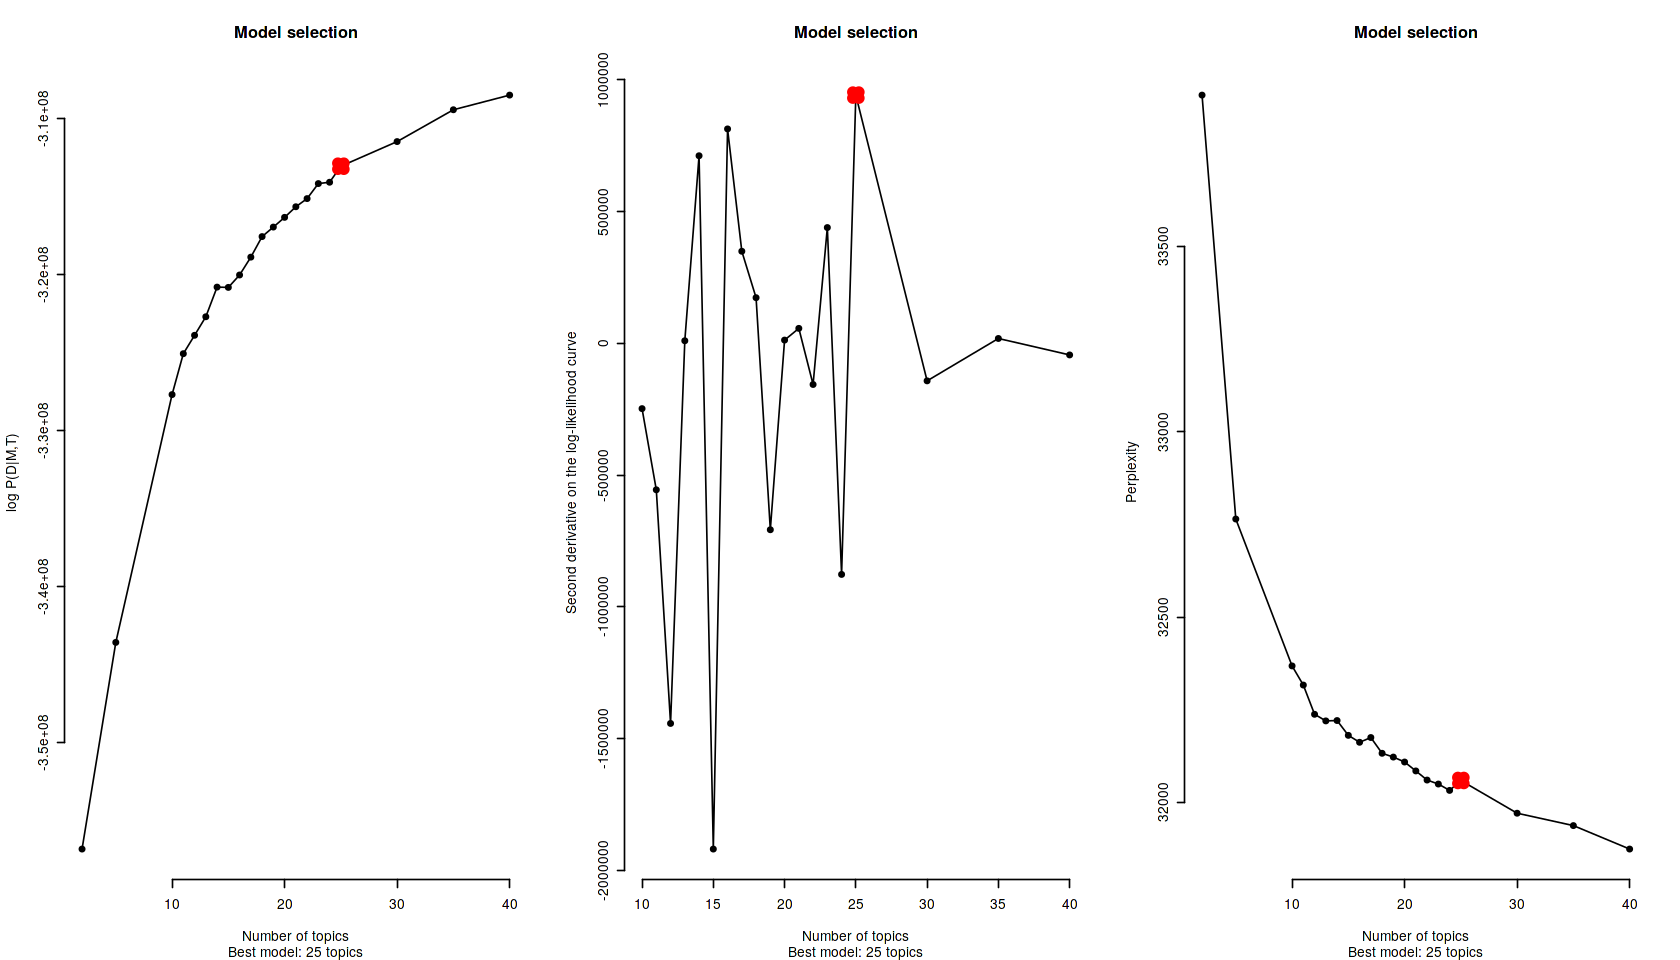

In [10]:
par(mfrow = c(1,3))

cisTopicObject <- selectModel(cisTopicObject, type='derivative')

Having the model selected, the LDA returns two distributions matrix recording topic assignments to cells and topic assignments to regions :

- the **topic contributions per cell** : matrix with *cells* as columns, topics as rows and contributions as values.

- the **region contribution to a topic** : matrix with *regions* as columns, topics as rows and contributions as values.

We can interpret these values as a dimensinality reduction method, after which the data is re-represented as a lower-dimentions matrix.

## 4. Interpreting the models
#### a. Analysis of the topic-cell contribution

Different methods can be used for clustering and/or visualization based on the LDA output. The most common ones are UMAP and t-SNE. Here, we will use the **topic contributions per cell matrix** (`target='cell'`) to compute UMAP and t-SNE. The results are saved in the slot `cisTopicObject@dr$cell`.

In [11]:
cisTopicObject <- runtSNE(cisTopicObject, target='cell', seed=123, pca=FALSE, method='Probability')
cisTopicObject <- runUmap(cisTopicObject, target='cell', seed=123, method='Probability')

The UMAP and t-SNE each provide a new 2-D embedding of the cells

In [12]:
dim(cisTopicObject@dr$cell$Umap)

[1] 5335    2

Once calculations are done, cisTopic offers a unified visualization function (`plotFeatures`), which allows to visualize tSNE, Umap, diffussion maps, principal components and biplots (in 2/3D), colored by metadata (e.g. from 10X metrics file) and/or topic enrichment.

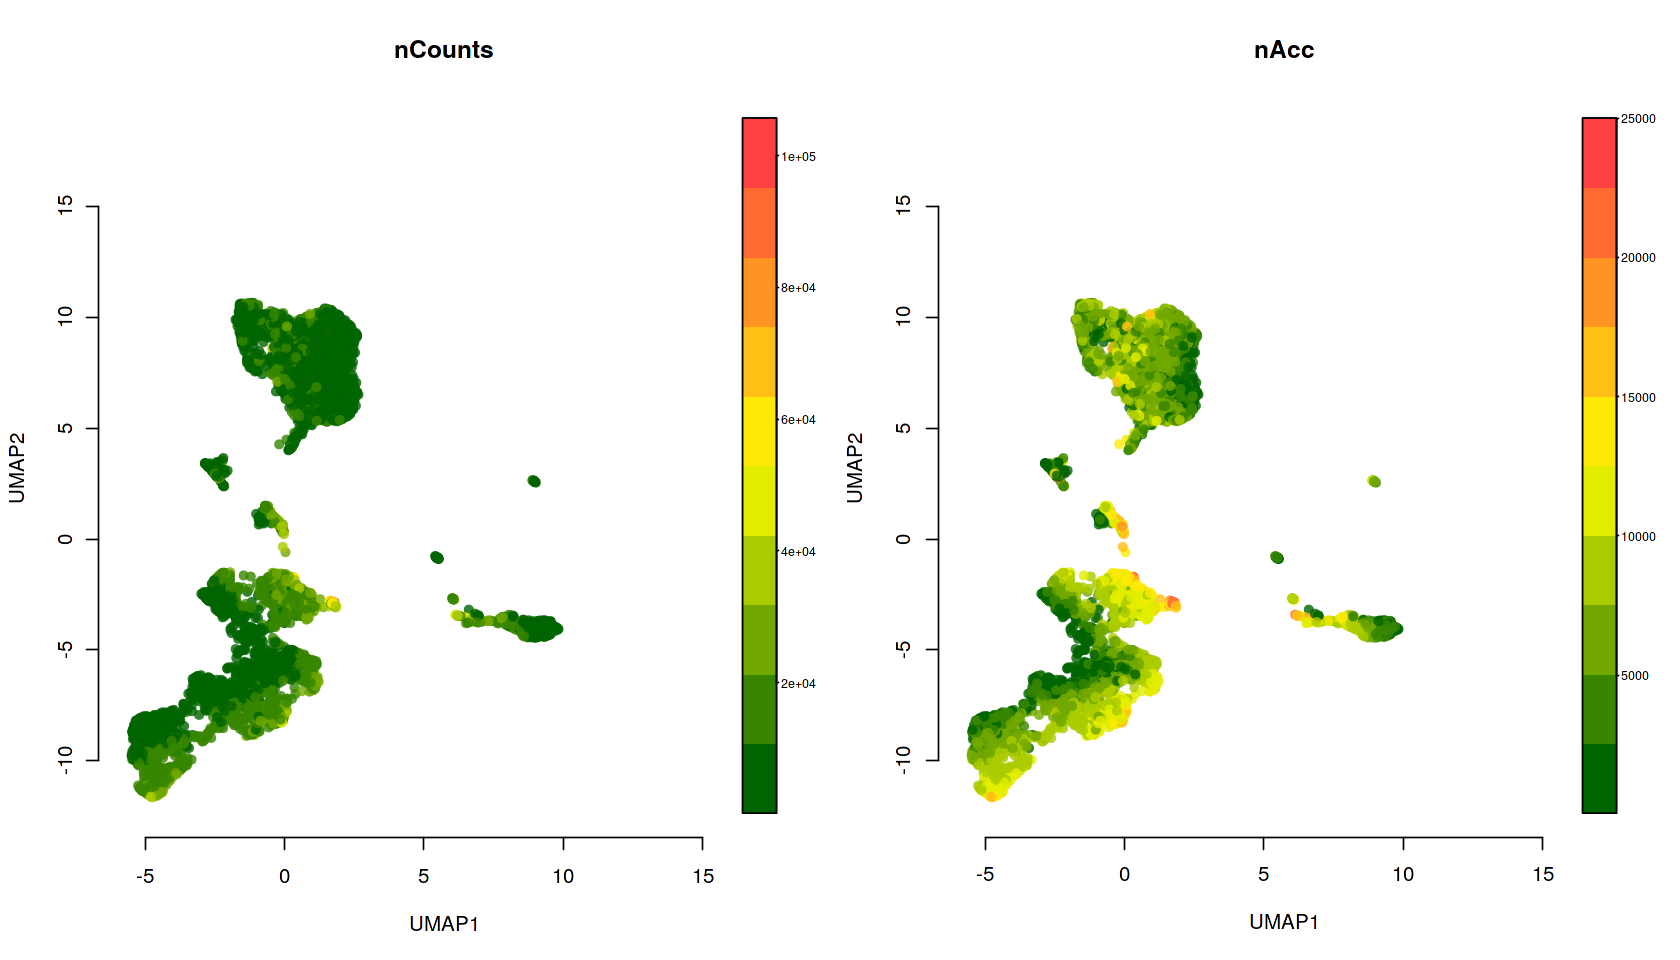

In [13]:
par(mfrow=c(1,2))

plotFeatures(cisTopicObject,
             method='Umap',
             target='cell',
             topic_contr=NULL,
             colorBy=c('nCounts', 'nAcc'),
             cex.legend = 0.8,
             factor.max=.75,
             dim=2,
             legend=TRUE,
             col.low='darkgreen',
             col.mid='yellow',
             col.high='brown1',
             intervals=10)

We can also generate a heatmap based on the **topic contributions per cell matrix**.

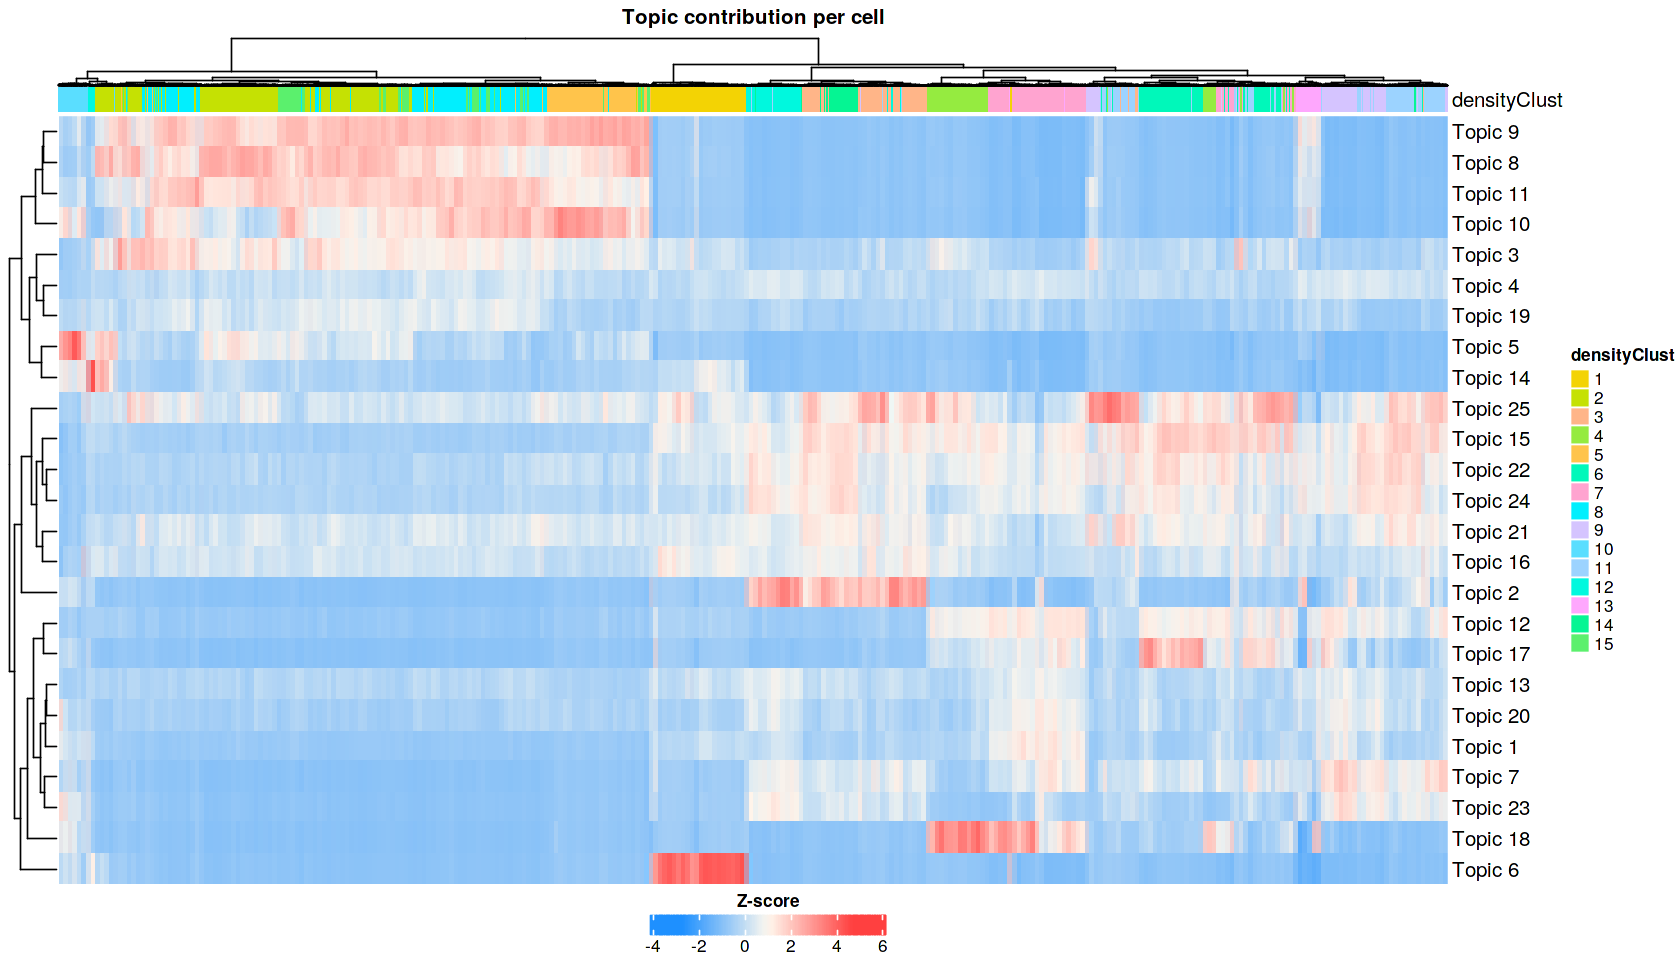

In [14]:
cellTopicHeatmap(cisTopicObject,
                 method='Z-score',
                 colorBy=c('densityClust'),
                 col.low = "dodgerblue",
                 col.mid = "floralwhite",
                 col.high = "brown1",
                 use_raster = TRUE)

As topic represents specific chromatin accessibility programs governing cell types, it is interesting to color the Umap by topic score.

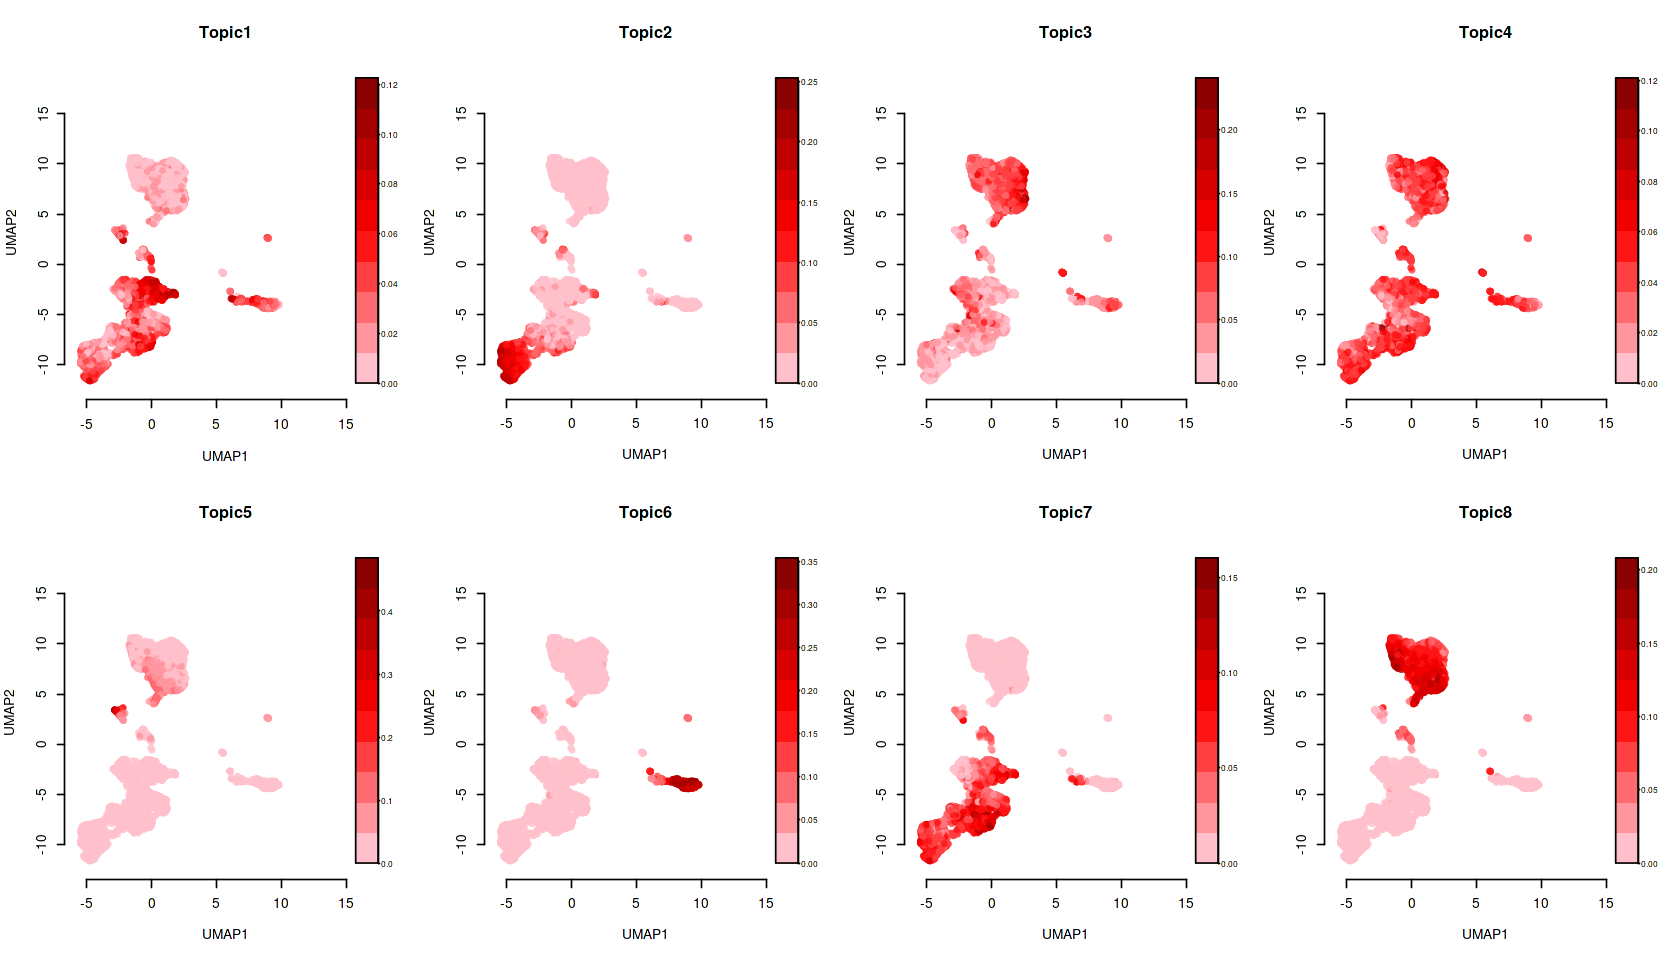

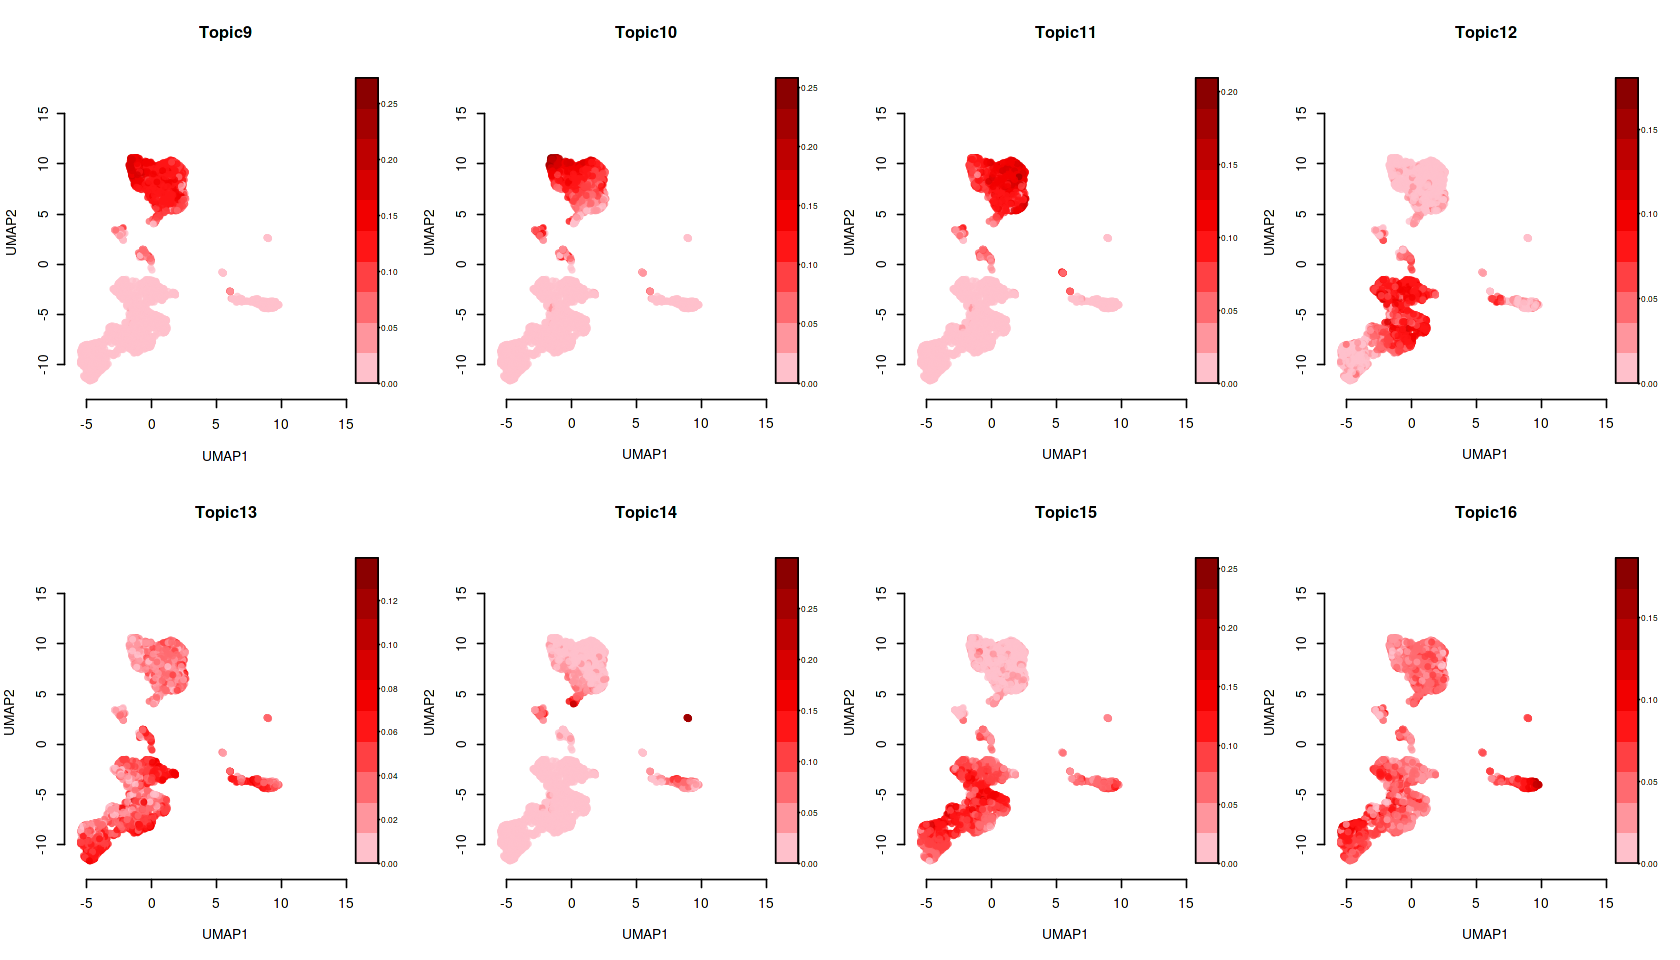

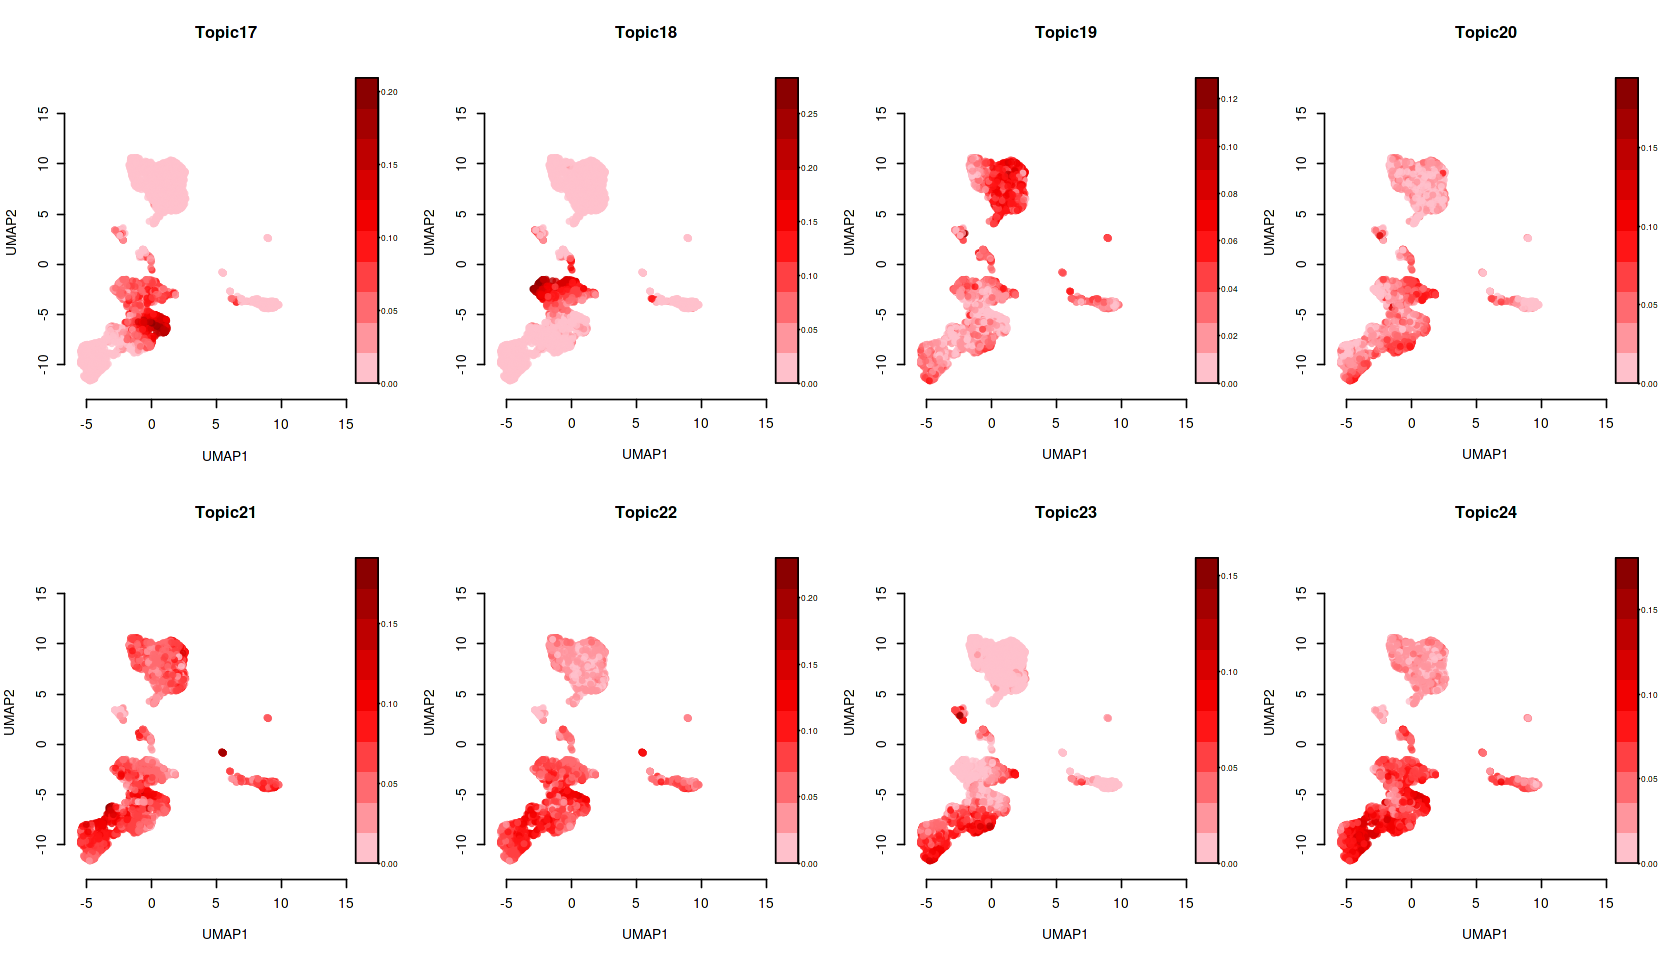

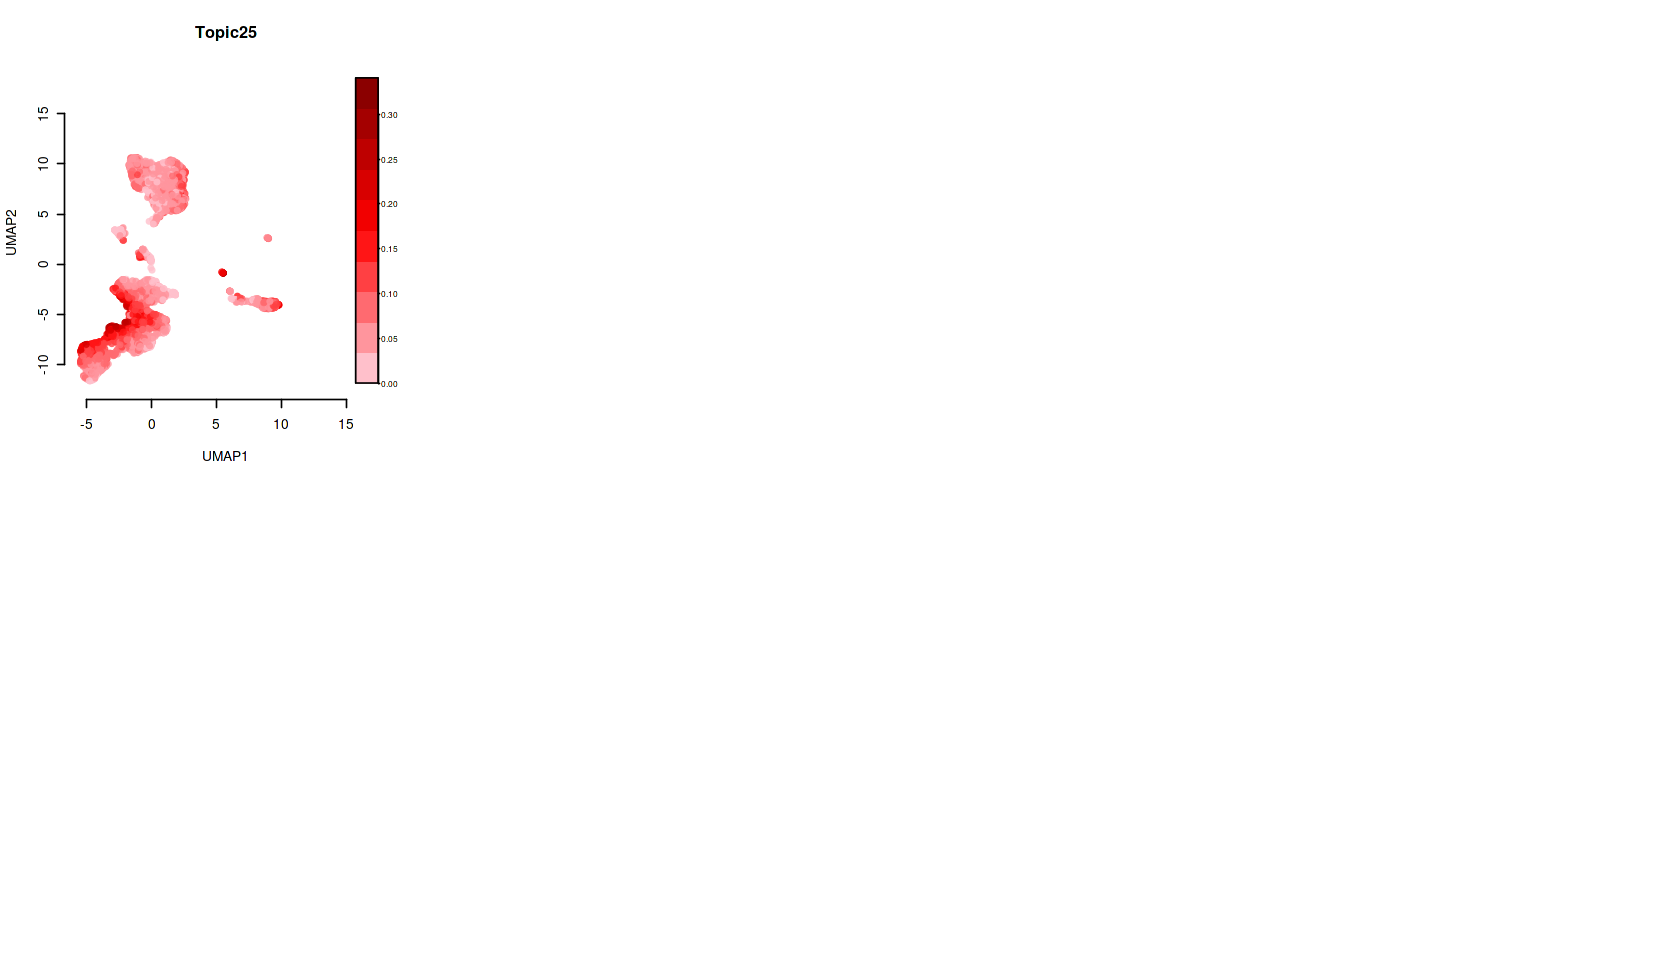

In [15]:
par(mfrow=c(2,4))

plotFeatures(cisTopicObject,
             method='Umap',
             target='cell',
             topic_contr='Probability',
             colorBy=NULL,
             cex.legend = 0.8,
             factor.max=.75,
             dim=2,
             legend=TRUE)

#### b. Analysis of the topic-regions contribution

Similarly to the topic-cell visualisation, we can take advantage of the **topic contributions per region matrix** to visualise the accessible genomic regions into t-SNE and UMAP embedding. As this matrix tends to be relatively large and noisy, we will perform severeal pre-processing steps to extract the relevant, high-confidence signal.

To analyze the regions included in the cisTopics, the first step is always to derive a score that evaluates how likely is for a region to belong to a topic. `getRegionsScores()` calculates these scores based on the *proportion of region specific assignments to a topic*. These scores can be rescaled into the range [0,1], which will be useful for the binarization step (see `GammaFit` method). This information is stored in the `region.data` slot of the cisTopicObject.

In [16]:
cisTopicObject <- getRegionsScores(cisTopicObject,
                                   method='NormTop',
                                   scale=TRUE)

BigWig files for observing the scored regions in the genome can be generated. Note that information on the length of the chromosomes has to be provided. These files can be uploaded in IGV or UCSC for visualisation. This information can be easily found in the TxDb objects of the corresponding genomes, for example.

In [17]:
# load genome info
txdb <- TxDb.Hsapiens.UCSC.hg19.knownGene

# Create BigWig file in specific output directory
bigwig_file_list <- getBigwigFiles(cisTopicObject, path='cisTopics_asBW', seqlengths=seqlengths(txdb))

However, many tools are limited to work with *sets* of regions rather than *rankings* of regions. To select a representative regions set that most contribute to a topic, we use `binarizecisTopics()` to select the top regions. This tool is based on two methods:
- `method = "Predefined"` : to select a predefined number of regions (determined by the cutoffs argument)
- `method = "GammaFit"` (default) : to automatically select a threshold based on a fit of the scores to a gamma distribution. This is recommended when using `method="NormTop" , scale=TRUE` in `getRegionScores()`. Note that the probability threshold must be provided by the user and it must be taken after the density (based on the fitted gamma distribution) is stabilised (i.e. in the tail of the distribution).

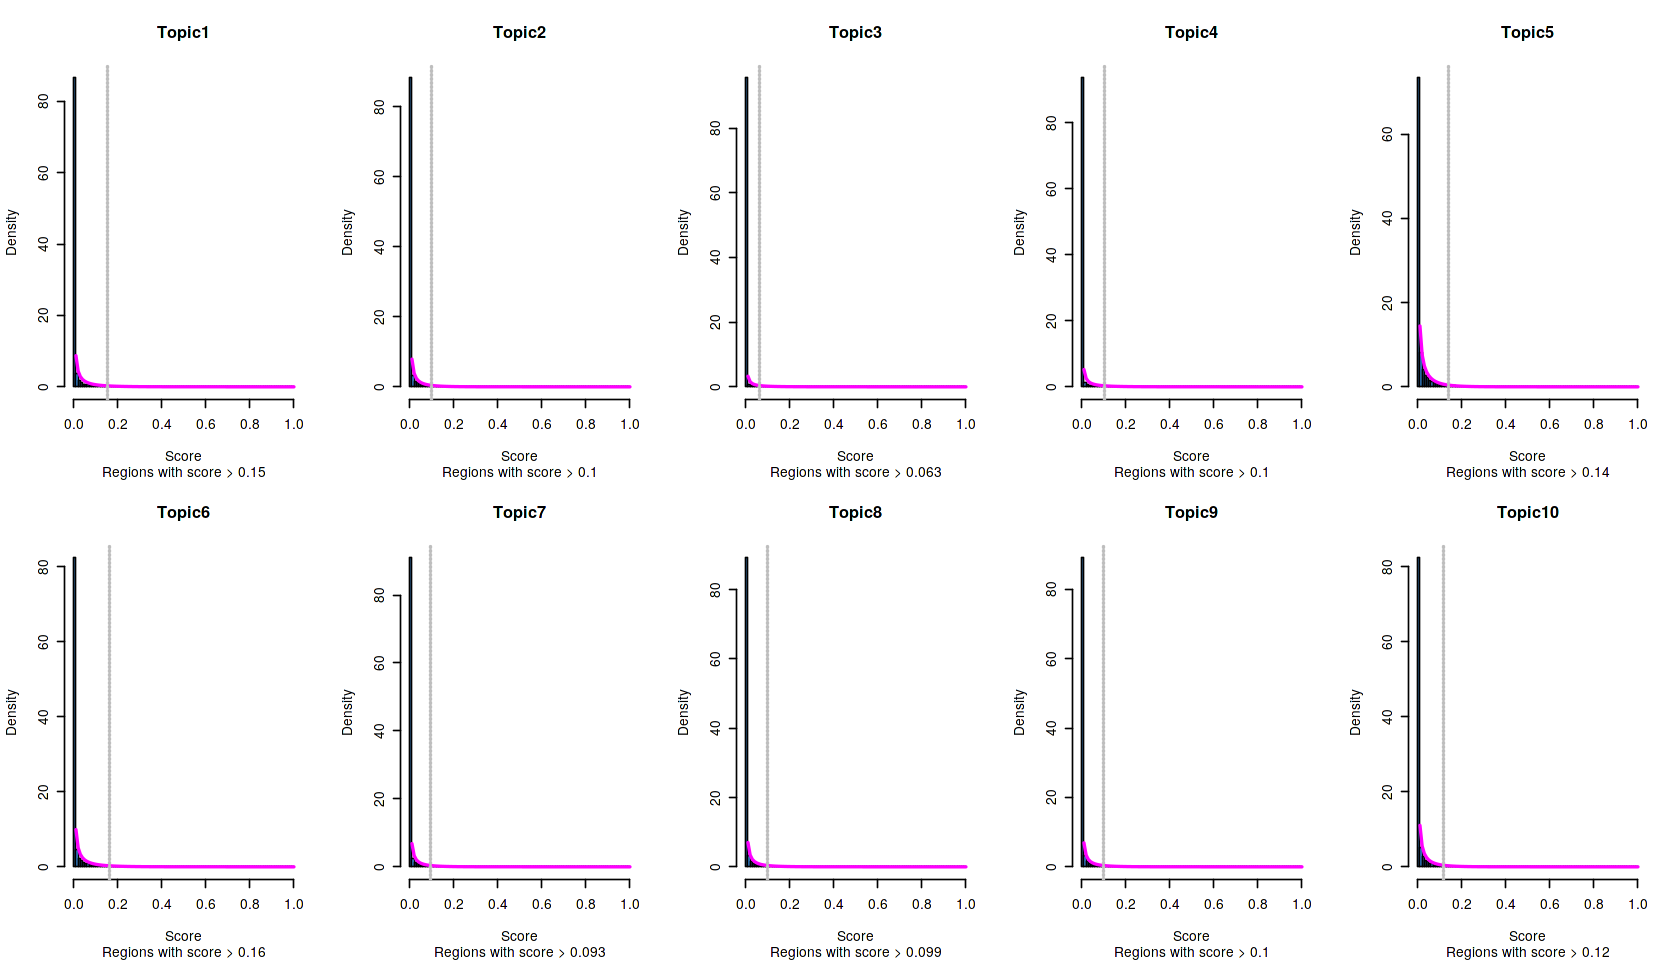

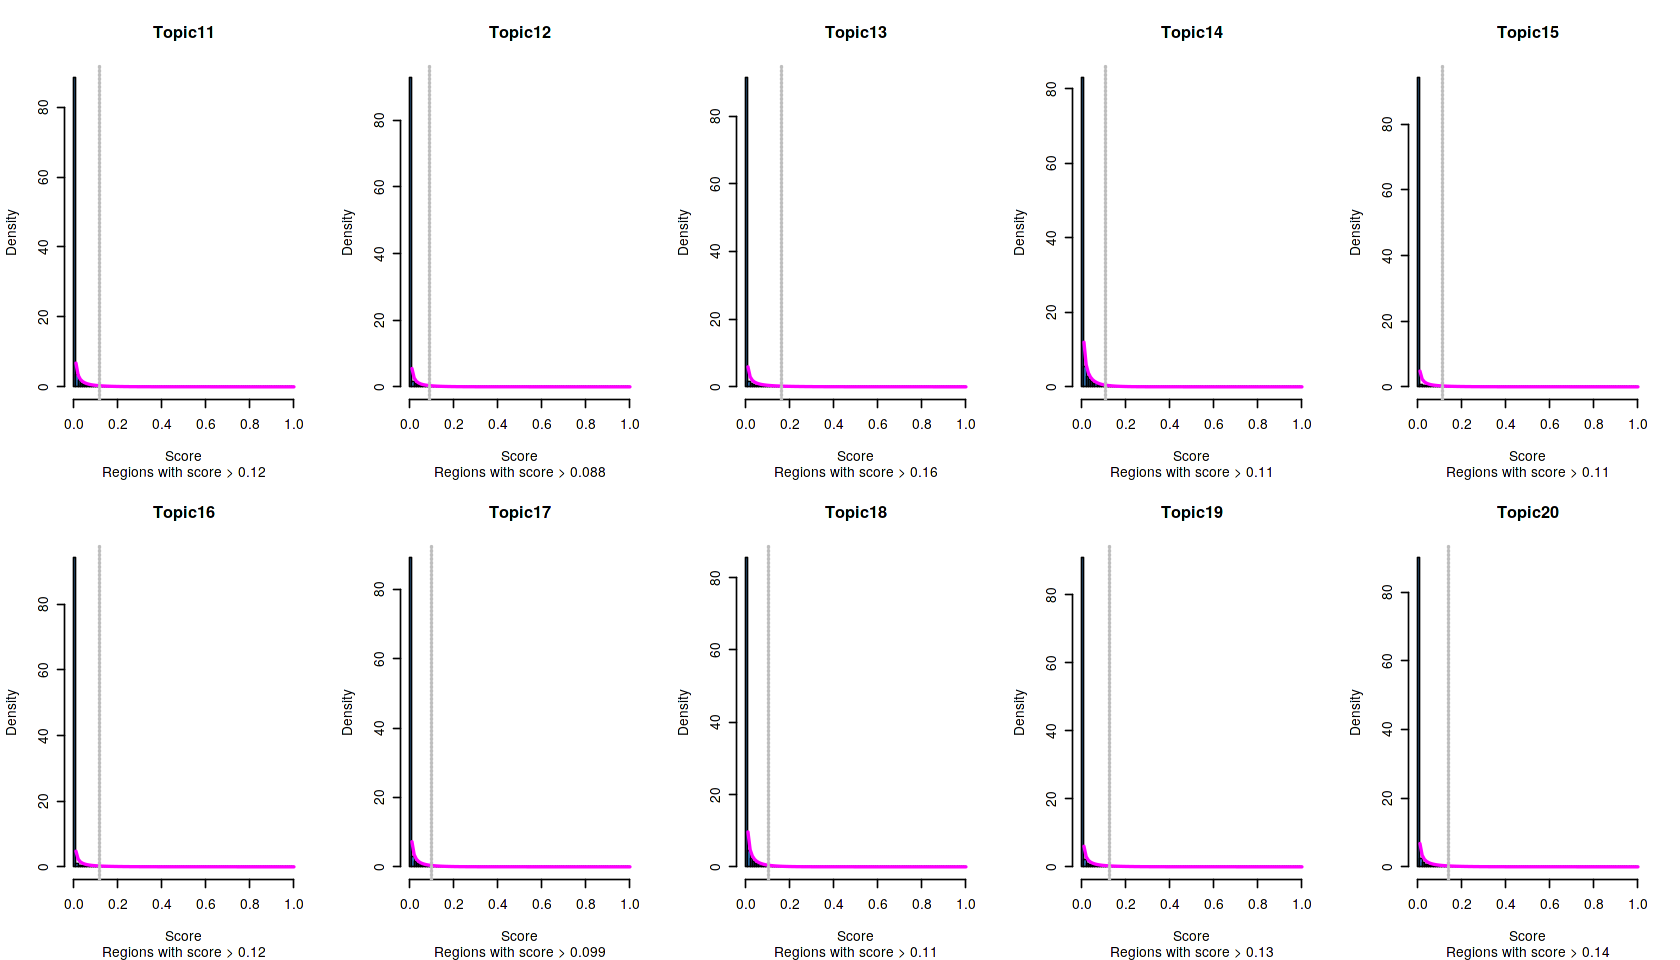

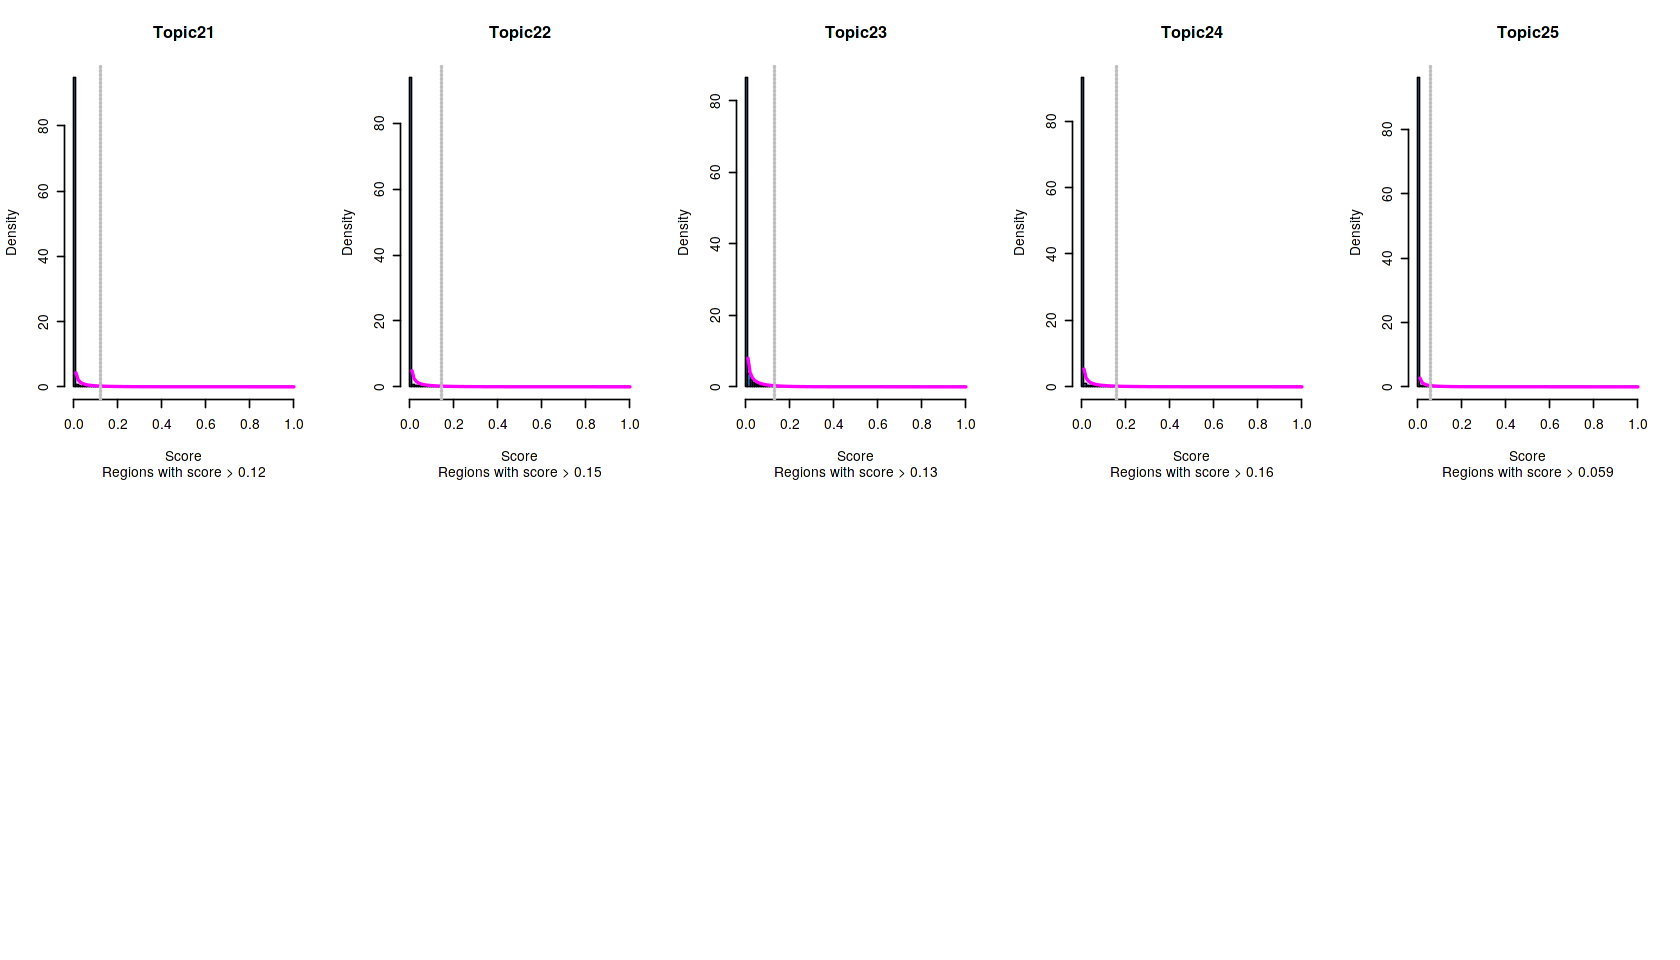

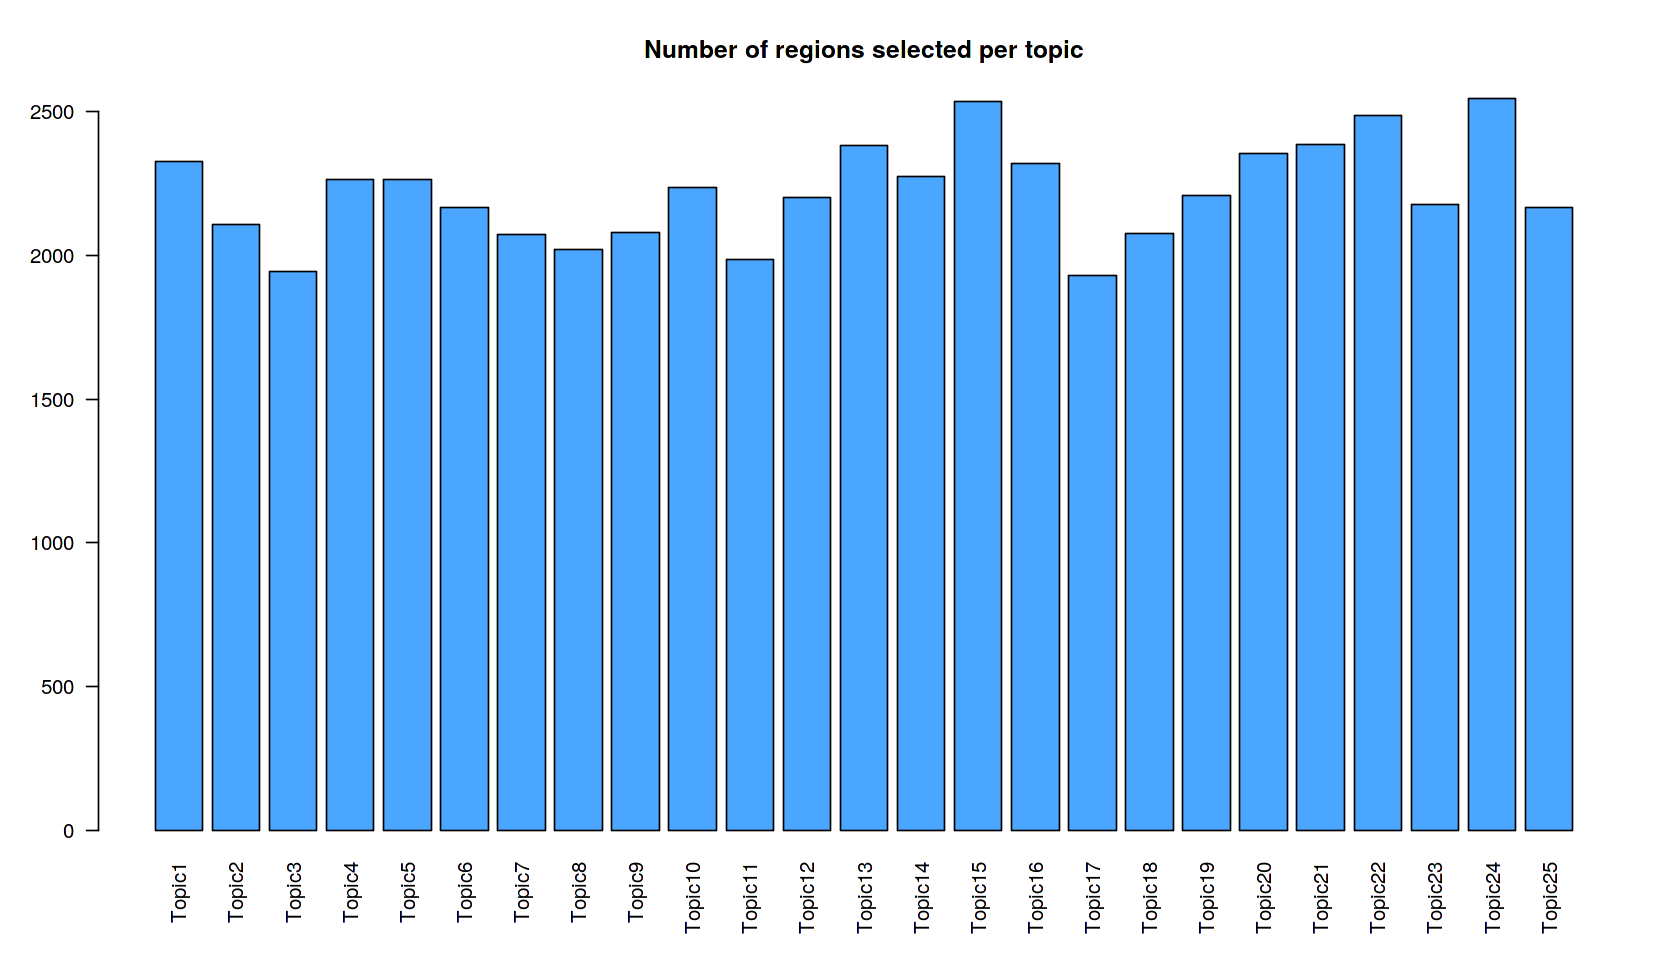

In [18]:
par(mfrow=c(2,5))
cisTopicObject <- binarizecisTopics(cisTopicObject,
                                    thrP=0.975, # probability threshold
                                    plot=TRUE)

Simiarly to the cell-topic visualisation from previous section, we can take advantage of the **topic score per regions matrix** for clustering and/or visualization. To compute a t-SNE or UMPA embedding in the case of regions, only high confidence regions (i.e. that pass the binarization threshold at least in 1 topic) are used. The results are saved in the slot `cisTopicObject@dr$region`. We use the same `runtSNE()` function as for cell-based embedding, but specifying `target='region'`.

In [19]:
cisTopicObject <- runtSNE(cisTopicObject, target='region', perplexity=200, check_duplicates=FALSE)

In [20]:
dim(cisTopicObject@dr$region$tSNE)

[1] 26911     2

Like for cell-based mapping, we can use the `plotFeature()` function to visualise the region-based embedding. Here, we will plot the t-SNE embedding and color the region by their contribution to each topic.

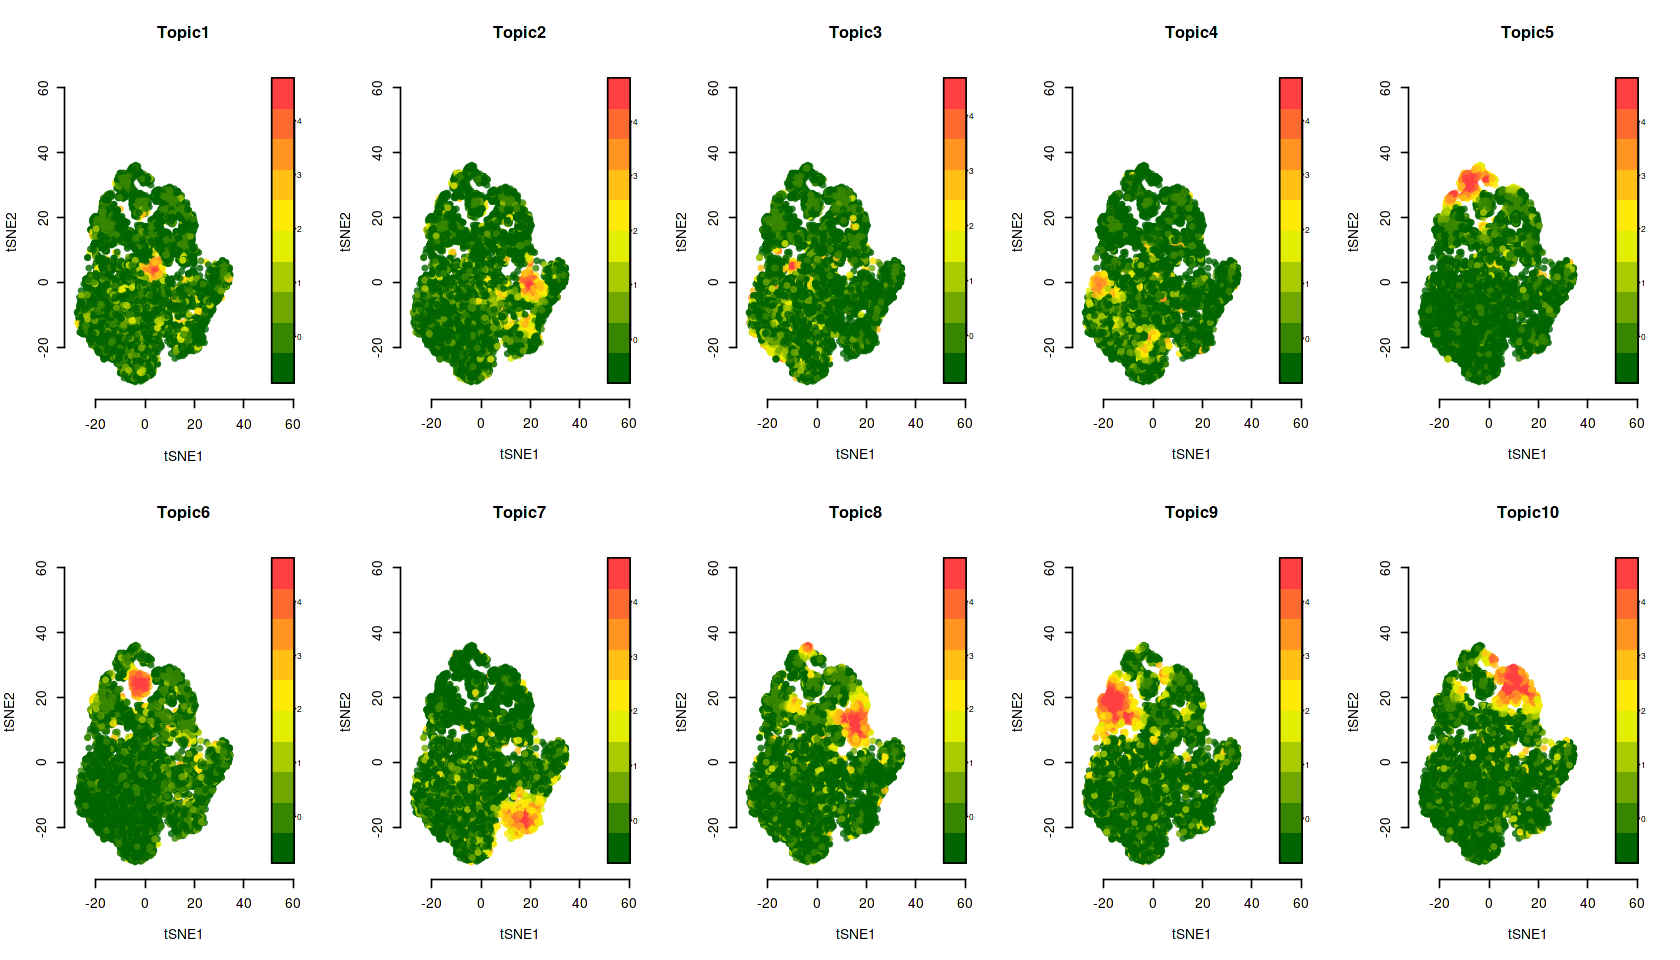

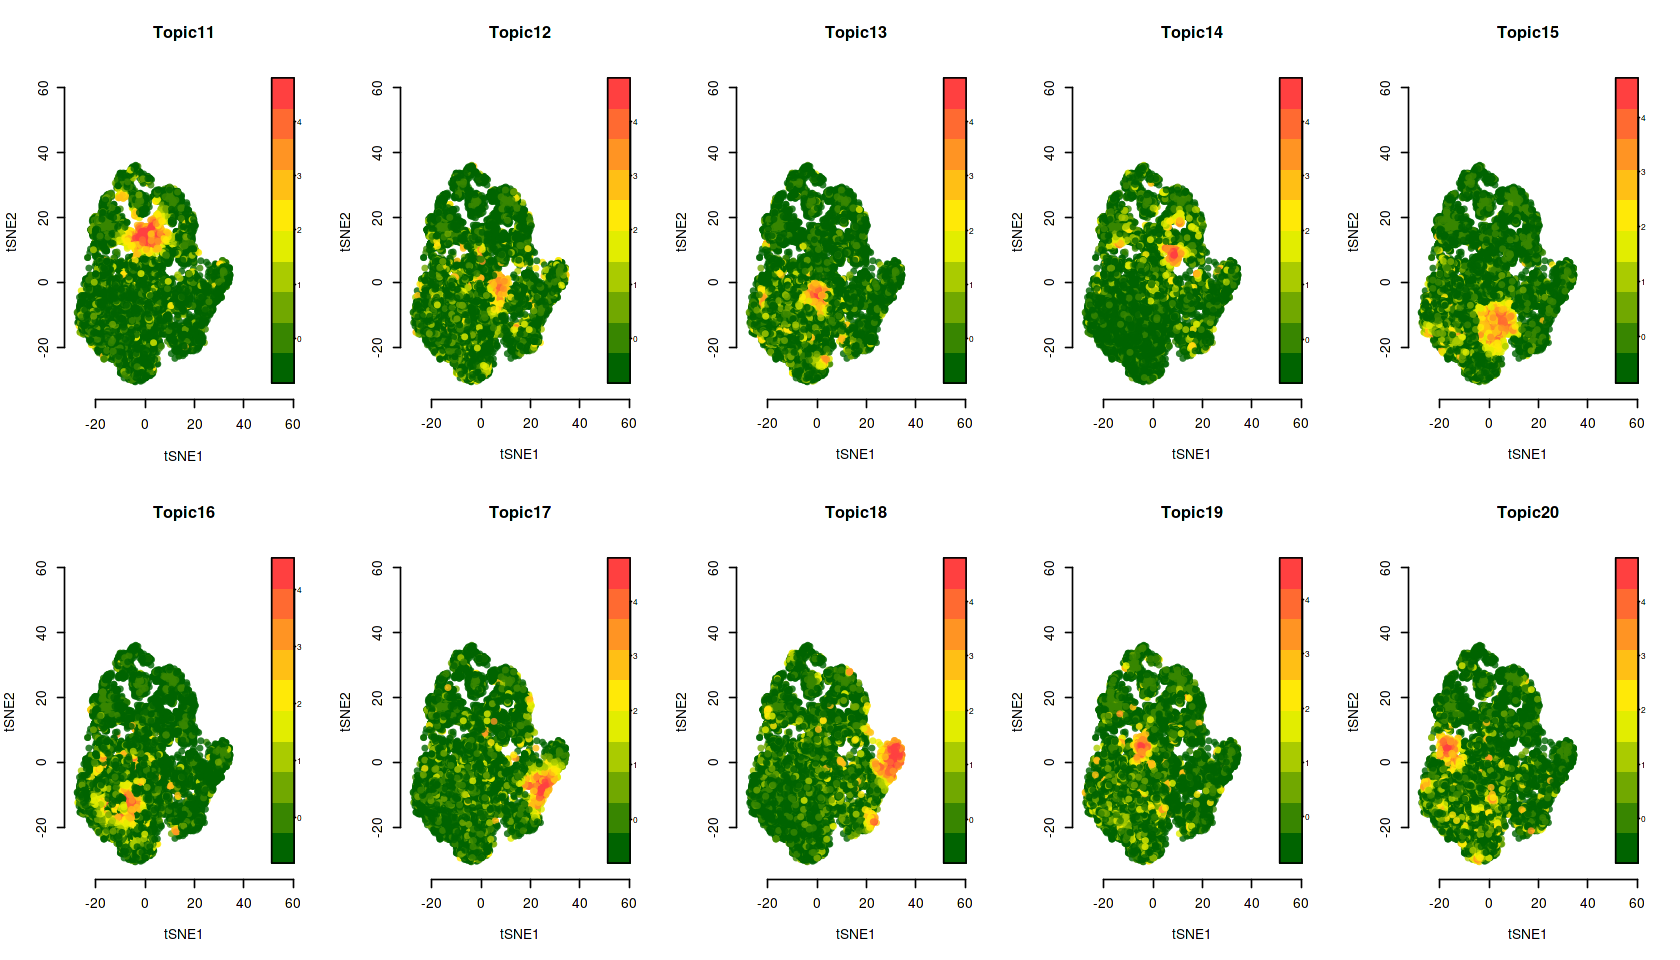

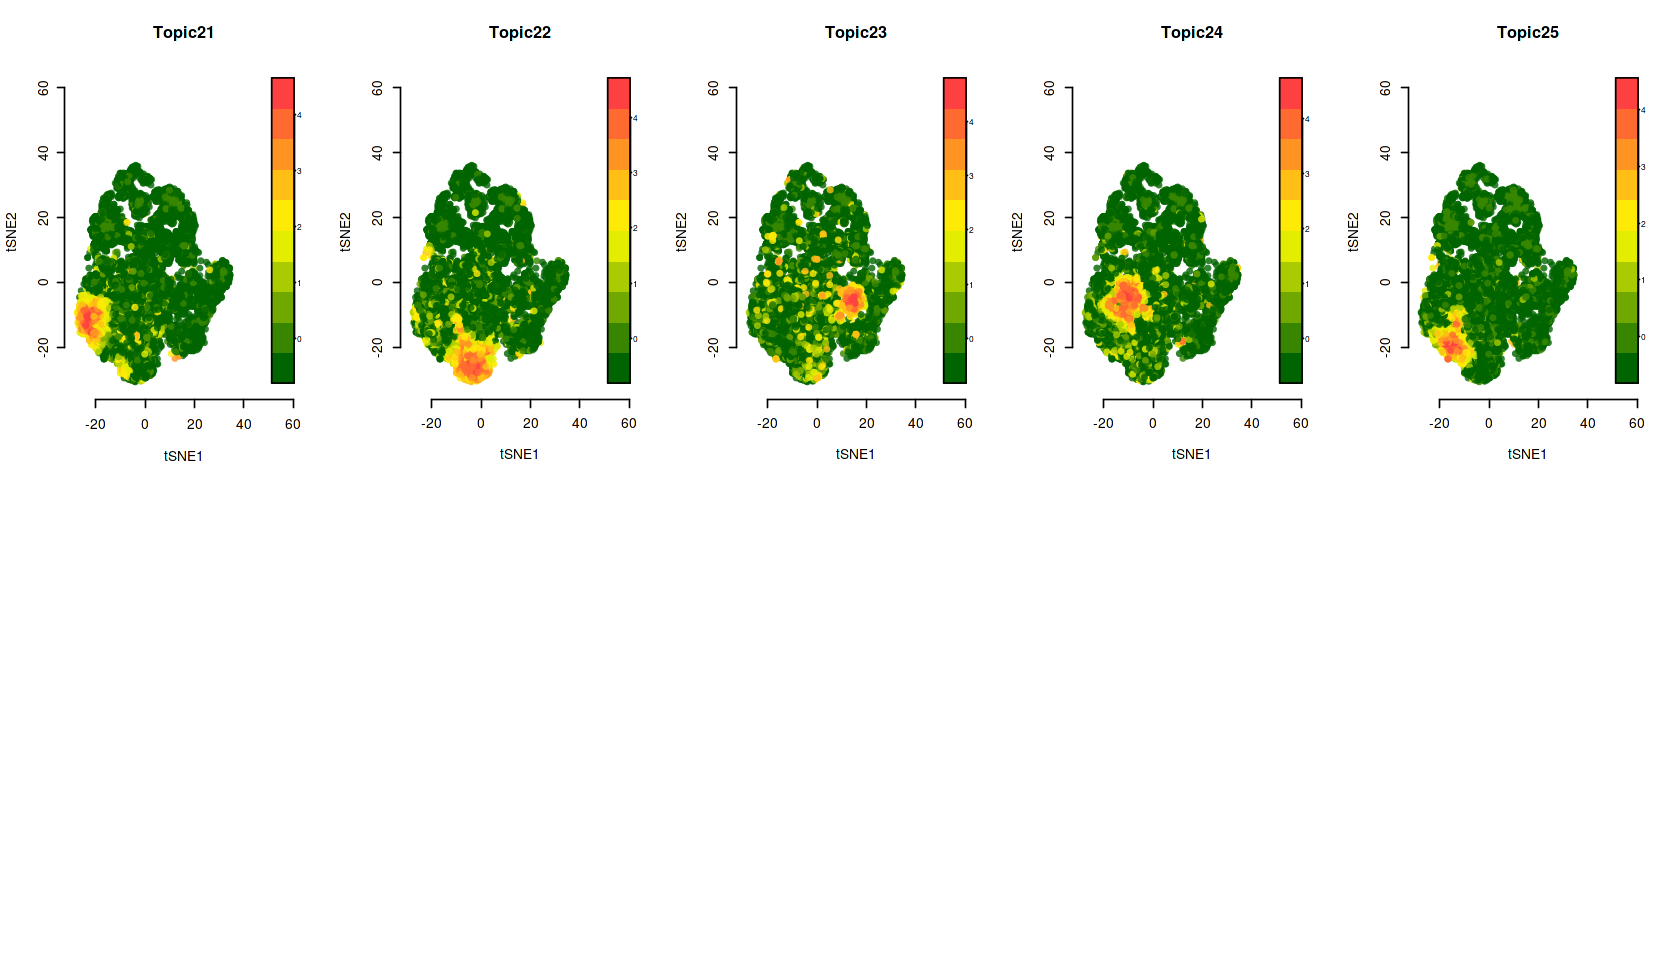

In [21]:
par(mfrow=c(2,5))

plotFeatures(cisTopicObject,
             method='tSNE',
             target='region',
             topic_contr='Z-score',
             colorBy=NULL,
             cex.legend = 0.8,
             factor.max=.75,
             dim=2,
             legend=TRUE,
             col.low='darkgreen',
             col.mid='yellow',
             col.high='brown1')

## 5. Extracting biological signature from the models

#### a. (Transcription factor) motif enrichment in topics

It is also possible to identify enriched motifs within the set of regions associated to each topic. To do this, we use **RcisTarget** (Aibar *et al.*, 2017). The current version provides databases for human (hg19). You can find the region-based database at: https://resources.aertslab.org/cistarget/

For this analysis, we first need to convert the binarized cisTopic regions to the regions in the databases (“ctx regions”). To do so, we convert the binarised topic regions to a set of equivalent ctx regions based on their *relative overlap* in genomic positions (a region can map to more than one ctx region).

In [22]:
cisTopicObject <- binarizedcisTopicsToCtx(cisTopicObject, genome='hg19')

Number of regions selected: 6031

Number of regions selected: 5487

Number of regions selected: 8711

Number of regions selected: 6138

Number of regions selected: 4555

Number of regions selected: 4983

Number of regions selected: 5646

Number of regions selected: 5478

Number of regions selected: 4911

Number of regions selected: 4815

Number of regions selected: 5163

Number of regions selected: 6969

Number of regions selected: 5960

Number of regions selected: 5886

Number of regions selected: 8006

Number of regions selected: 6676

Number of regions selected: 4976

Number of regions selected: 4803

Number of regions selected: 5661

Number of regions selected: 6830

Number of regions selected: 7280

Number of regions selected: 6833

Number of regions selected: 5829

Number of regions selected: 7027

Number of regions selected: 9674



We are now ready to run **RcisTarget** in each topic using the wrapper function `topicsRcisTarget()`. This function uses the binarised topic regions converted to ctx regions to score enrichment in transcription factor binding motif for each topic. For the sake of time, we will not run this command in this tutorial but use the pre-computed results available in the cisTopicObject.

In [ ]:
# To run RcisTarget on the ctx-converted topics
#pathToFeather <- "/staging/leuven/res_00001/databases/cistarget/databases/homo_sapiens/hg19/refseq_r45/mc8nr/region_based/hg19-regions-9species.all_regions.mc8nr.feather"
#cisTopicObject <- topicsRcisTarget(cisTopicObject, genome='hg19', pathToFeather, reduced_database=FALSE, nesThreshold=3, rocthr=0.005, maxRank=20000, nCores=5)

Once RcisTarget is run, the enrichment results are stored in the `cisTopicObject@binarized.RcisTarget` slot. The interactive motif enrichment tables can be explored (e.g. per topic) using the **DT** package:

In [23]:
Topic6_motif_enr <- cisTopicObject@binarized.RcisTarget[[6]]
DT::datatable(Topic6_motif_enr[,-c("enrichedRegions", "TF_lowConf"), with=FALSE], escape = FALSE, filter="top", options=list(pageLength=5))

HTML widgets cannot be represented in plain text (need html)

In [24]:
Topic10_motif_enr <- cisTopicObject@binarized.RcisTarget[[10]]
DT::datatable(Topic10_motif_enr[,-c("enrichedRegions", "TF_lowConf"), with=FALSE], escape = FALSE, filter="top", options=list(pageLength=5))

HTML widgets cannot be represented in plain text (need html)

We find SPI1 and CEBPB as master regulators, for example, of the topics 6 and 10, respectively.


#### b. Identification of cell types using the predictive cell-region distribution

By multiplying the cell-topic and region-topic contribution matrices, we can compute the likelihood of each region in each cell (i.e. **predictive distribution**). This matrix is stored in the `cisTopicObject@predictive.distribution` slot. These distributions can be used to estimate drop-outs and build cell-specific region rankings that can be used with AUCell for estimating the enrichment of epigenomic signatures within the cells.

In [25]:
pred.matrix <- predictiveDistribution(cisTopicObject)

# Get matrix dimensions
dim(pred.matrix)

[1] 97997  5335

With this preditctive distribution, we can evaluate which cells are more enriched for certain **ChIP-seq signatures** :

First, epigenomic regions are *intersected and mapped* to regions in the dataset (by default, with at least 40% overlap) using the function `getSignaturesRegions()`.

In this tutorial, we will use bulk ChIP-seq signatures from the hematopoietic system from Corces *et al.* (2016).

In [26]:
# Reset Signatures in the CisTopicObject
cisTopicObject@signatures <- list()

# Obtain signatures
path_to_signatures <- paste0(pathTo10X,"BulkPeaks/")
Bulk_ATAC_signatures <- paste(path_to_signatures, list.files(path_to_signatures, pattern = "*narrowPeak"), sep='')
labels  <- gsub('._peaks.narrowPeak', '', list.files(path_to_signatures))

cisTopicObject <- getSignaturesRegions(cisTopicObject, Bulk_ATAC_signatures, labels=labels, minOverlap = 0.4)

The signature contains 73992 of which 44681 overlap the regions in the set.

The signature contains 88601 of which 52308 overlap the regions in the set.

The signature contains 88243 of which 49863 overlap the regions in the set.

The signature contains 79250 of which 49198 overlap the regions in the set.

The signature contains 83681 of which 51755 overlap the regions in the set.

The signature contains 65248 of which 51514 overlap the regions in the set.

The signature contains 82458 of which 48238 overlap the regions in the set.



In [27]:
# To only keep unique peaks per signature
cisTopicObject@signatures <- llply(1:length(cisTopicObject@signatures),
                                   function (i) cisTopicObject@signatures[[i]][-which(cisTopicObject@signatures[[i]] %in% unlist(as.vector(cisTopicObject@signatures[-i])))]) 
names(cisTopicObject@signatures) <- labels

To test the enrichment of these signatures in each cell, we use a **GSEA-like** recovery curve ranking-based approach.

In each cell, regions are ranked based on their probability (x-axis), and when a region is present in the signature we increase one step in the y-axis. The **Area Under the Curve (AUC)** is used to evaluate the importance of that signature within that cell.

In [28]:
# Compute cell rankings
aucellRankings <- AUCell_buildRankings(pred.matrix, plot=FALSE, verbose=FALSE)

In [29]:
# AUCell results are quite large
sl <- object.size(aucellRankings)
print(sl, units = "Mb")

2011.7 Mb


The final signature enrichment analysis is done in CisTopic with the function `signatureCellEnrichment()`. The ChIP-overlapping region sets (which are stored in `cisTopicObject@signatures`) are used as input, together with the cell-specific region rankings. AUC values for each specific signature are stored in `cisTopicObject@cell.data`.

In [30]:
# Check signature enrichment in cells
cisTopicObject <- signatureCellEnrichment(cisTopicObject,
                                          aucellRankings,
                                          selected.signatures='all',
                                          aucMaxRank = 0.3*nrow(aucellRankings),
                                          plot=FALSE)

Running the `signatureCellEnrichment()` function adds new metadata into the cisTopicObject named `labels`. This metrics correspond to the score of ChIP-seq derived signature for each cell in the dataset. We can visualize this score in the cell-based UMAP embedding with the `plotFeature()` function and using `colorBy=labels`.

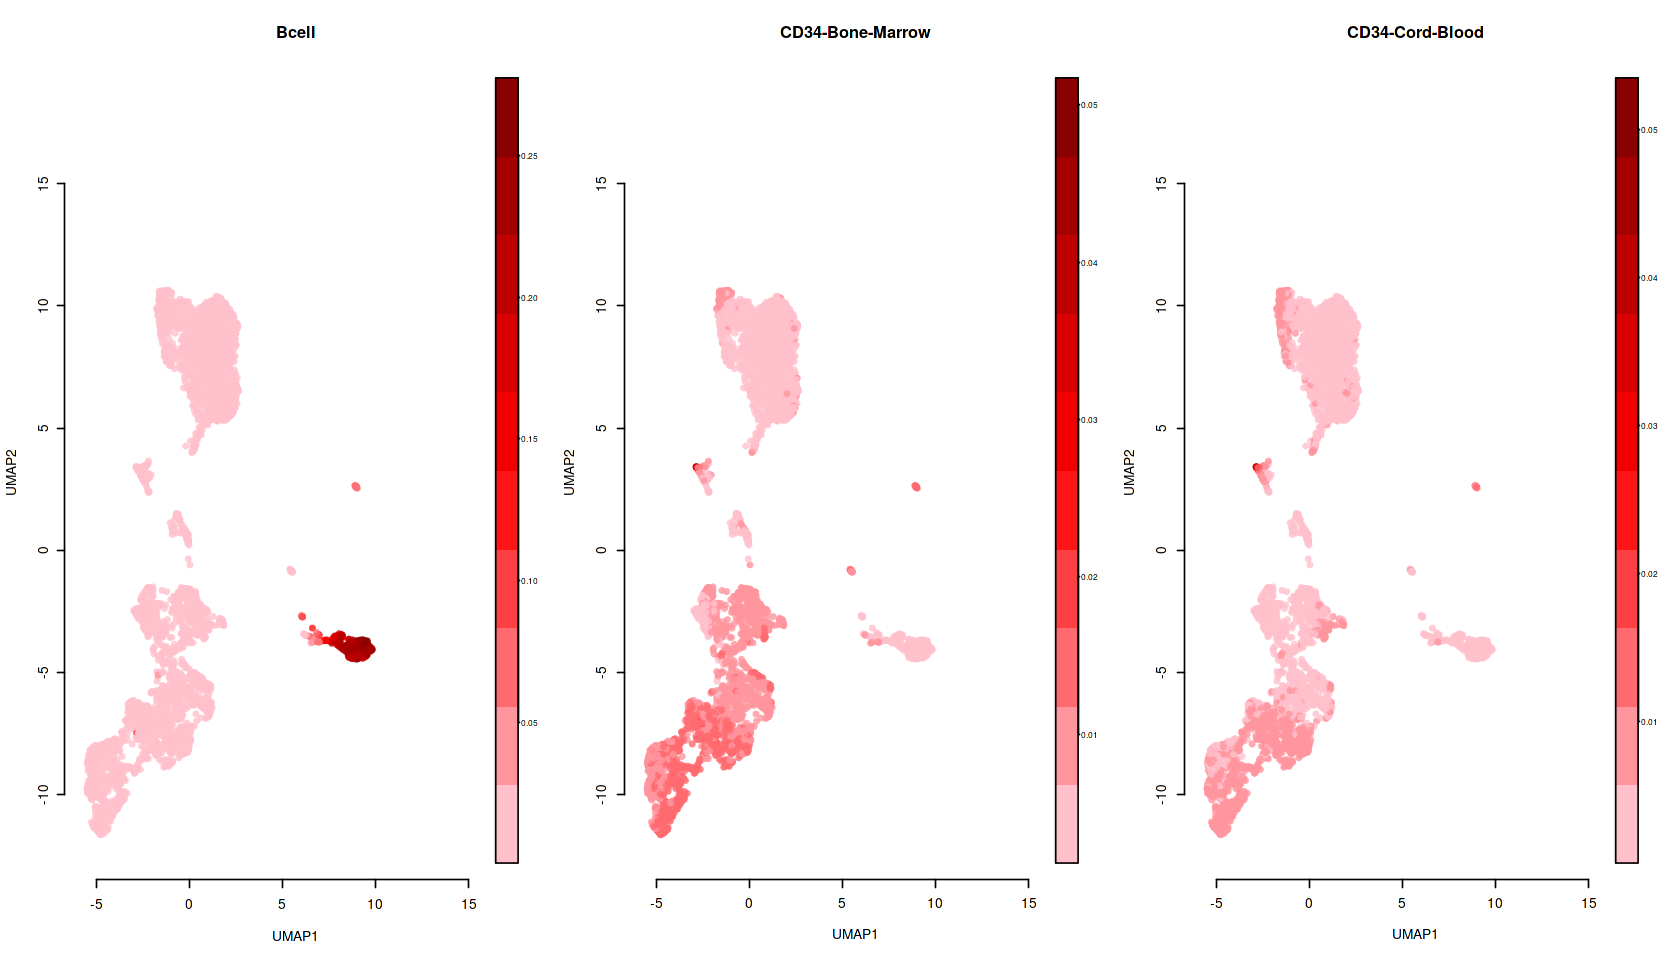

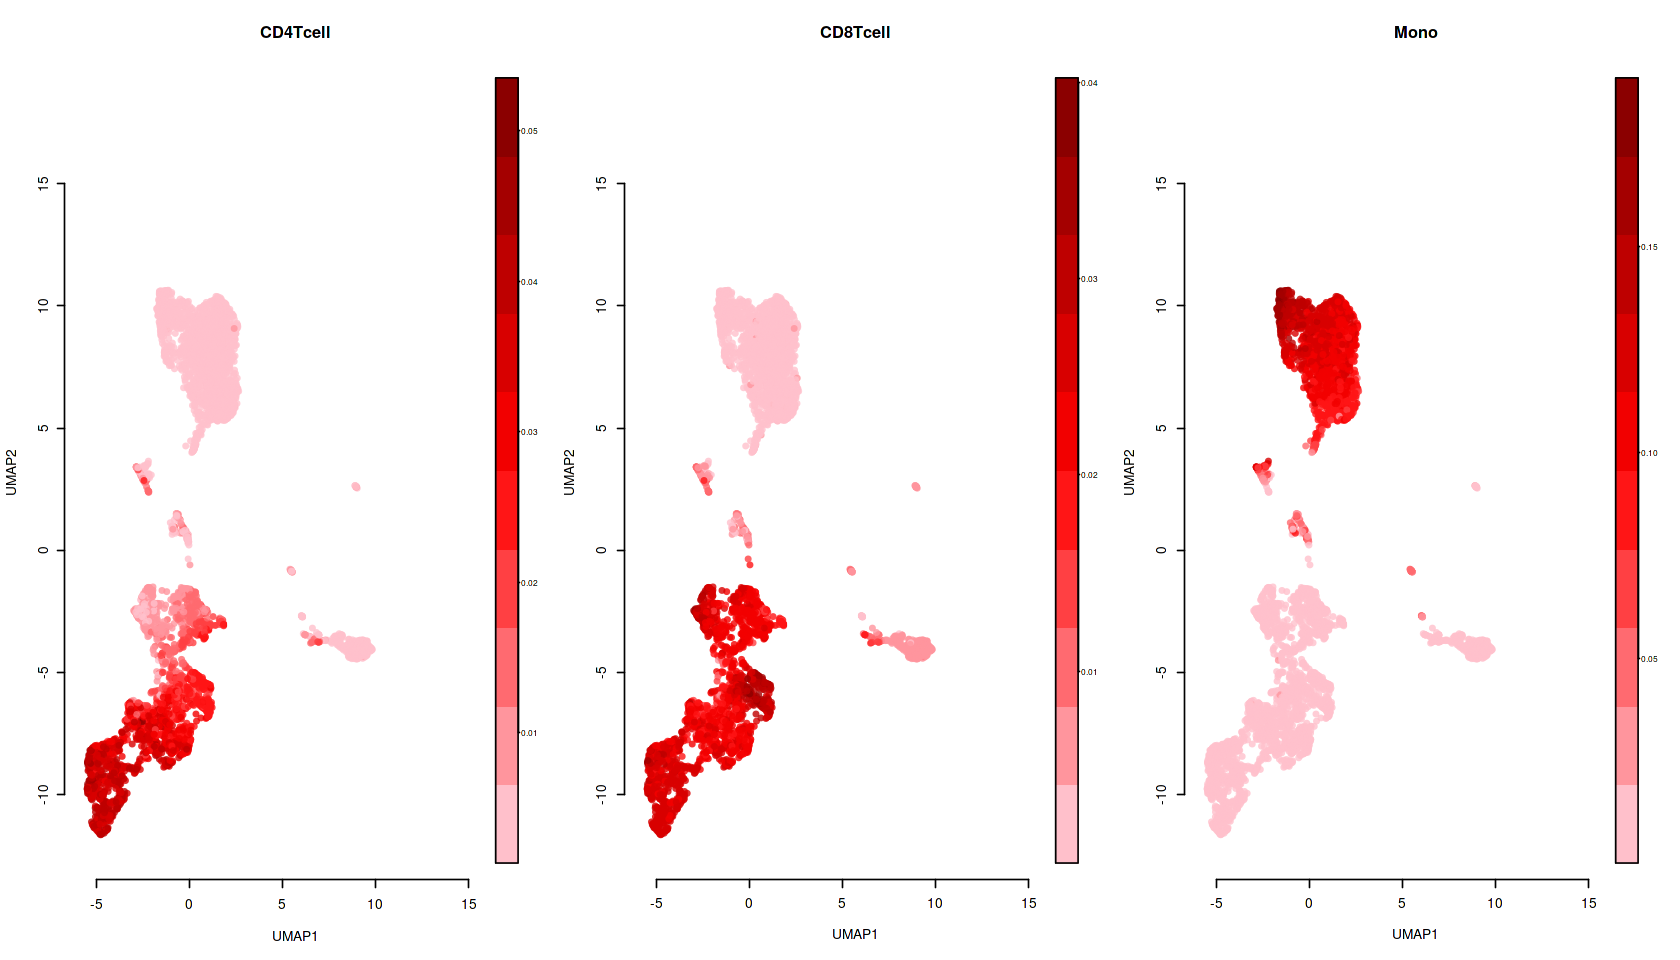

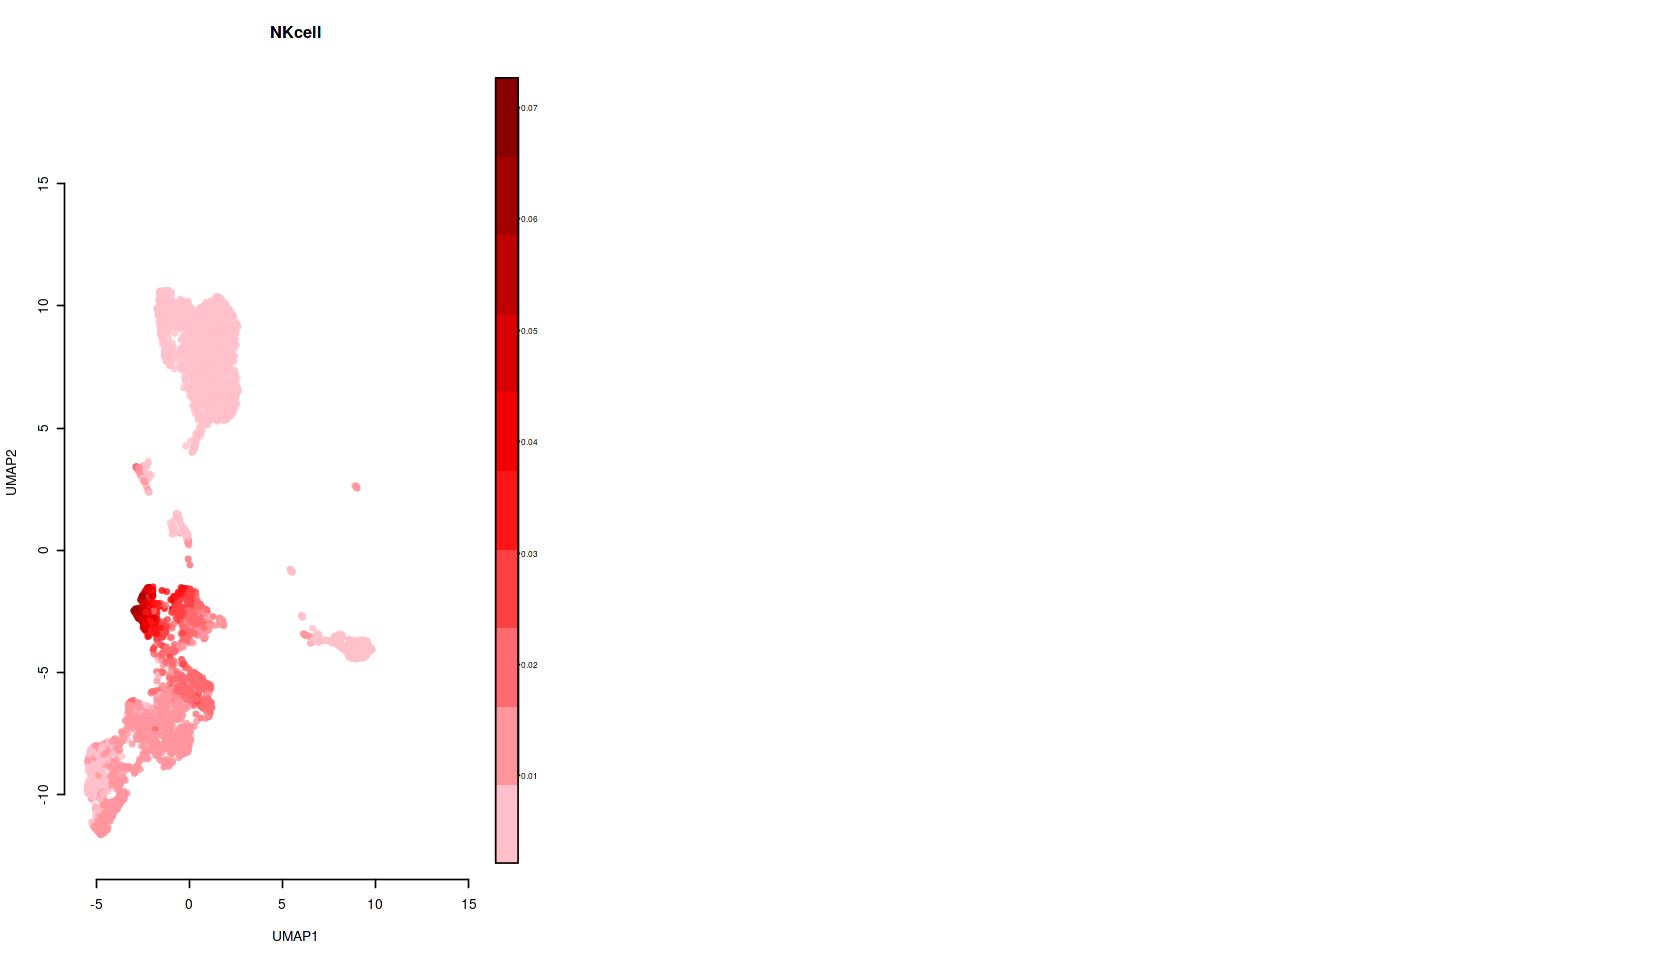

In [31]:
# Plot
par(mfrow=c(1,3))

plotFeatures(cisTopicObject,
             method='Umap',
             target='cell',
             topic_contr=NULL,
             colorBy=labels,
             cex.legend = 0.4,
             factor.max=.75,
             dim=2,
             legend=TRUE,
             intervals=10)

## 5. Exporting results to loom file

Now that we have processed our PBMC data using cisTopic, we can save the cisTopic object as a RDS object using the `saveRDS()`. Additionally, we can export the results into a loom file for visualisation into SCope using the `SCopeLoomR` package.

Here, we will save the cell-based t-SNE and UMAP embedding as well as the predictive distribution matrix. We mulpliply region-cells probabilities by 10ˆ2 before exporting to reduce its sparsity (values are rounded to integer).

In [32]:
# Prepare prediction matrix
pred.matrix <- round(pred.matrix*10^2)

In [33]:
# Prepare embedding
default.tsne <- cisTopicObject@dr$cell$tSNE
default.tsne.name <- "t-SNE on cell-topics contribution matrix"
head(default.tsne)

default.umap <- cisTopicObject@dr$cell$Umap
default.umap.name <- "UMAP on cell-topics contribution matrix"
head(default.umap)

# Prepare metadata (Cell type signature and Topic contribution)
cell.topic.mat <- t(modelMatSelection(cisTopicObject,
                  target = "cell",
                  method = "Z-score"))
meta.data <- cbind(cisTopicObject@cell.data, cell.topic.mat)

tSNE1     tSNE2      
AAACGAAAGCGCAATG-1  24.37763 -22.9053080
AAACGAAAGGGTATCG-1   9.31826  -7.1351341
AAACGAAAGTAACATG-1 -15.50552   0.4065058
AAACGAAAGTTACACC-1 -21.45313  -2.6458994
AAACGAACAGAGATGC-1  23.41642  -8.4830155
AAACGAACATGCTATG-1  30.00312 -19.8841359

UMAP1     UMAP2    
AAACGAAAGCGCAATG-1 1.8924318  9.994888
AAACGAAAGGGTATCG-1 0.2102075  7.311958
AAACGAAAGTAACATG-1 0.8385949 -3.359484
AAACGAAAGTTACACC-1 0.1050256 -2.874596
AAACGAACAGAGATGC-1 1.5840354  7.647098
AAACGAACATGCTATG-1 2.5597473  9.291333

In [34]:
# Build minimal loom
file.name <- "cistopic_5k_pbmc.loom"

build_loom(
  file.name=file.name,
  dgem=pred.matrix,
  title="10X scATAC-seq of 5k PBMCs",
  genome="Human",
  default.embedding=default.tsne,
  default.embedding.name=default.tsne.name
)

[1] "Adding global attributes..."


Warning message in if (class(x = dgem) == "dgTMatrix") {:
“la condition a une longueur > 1 et seul le premier élément est utilisé”


[1] "Adding matrix..."
  |======================================================================| 100%[1] "Adding column attributes..."
[1] "Adding default metrics nUMI..."
[1] "Adding default metrics nGene..."
[1] "Adding default embedding..."
[1] "Adding row attributes..."
[1] "Adding columns graphs..."
[1] "Adding row graphs..."
[1] "Adding layers..."


In [35]:
# Open loom in writting mode
loom <- open_loom(file.name, mode = "r+")

# Add hierarchy
add_hierarchy(loom = loom,
              hierarchy = create_hierarchy(level.1.name = "Human",
                                           level.2.name = "PBMC",
                                           level.3.name = "scATAC"))

# Add embedding
add_embedding(loom=loom,
              embedding=default.umap,
              name=default.umap.name)

# Add numerical metadata
for (i in c(labels, paste0("Topic", 1:25), "nCounts", "nAcc")){
    print(paste("Adding info for",i))
    add_col_attr(loom=loom, key = i,
             value=meta.data[,i],
             as.metric = T)
}

# Close connection to loom file
close_loom(loom)

[1] "Adding embedding UMAP on cell-topics contribution matrix..."
[1] "Adding info for Bcell"
[1] "Adding info for CD34-Bone-Marrow"
[1] "Adding info for CD34-Cord-Blood"
[1] "Adding info for CD4Tcell"
[1] "Adding info for CD8Tcell"
[1] "Adding info for Mono"
[1] "Adding info for NKcell"
[1] "Adding info for Topic1"
[1] "Adding info for Topic2"
[1] "Adding info for Topic3"
[1] "Adding info for Topic4"
[1] "Adding info for Topic5"
[1] "Adding info for Topic6"
[1] "Adding info for Topic7"
[1] "Adding info for Topic8"
[1] "Adding info for Topic9"
[1] "Adding info for Topic10"
[1] "Adding info for Topic11"
[1] "Adding info for Topic12"
[1] "Adding info for Topic13"
[1] "Adding info for Topic14"
[1] "Adding info for Topic15"
[1] "Adding info for Topic16"
[1] "Adding info for Topic17"
[1] "Adding info for Topic18"
[1] "Adding info for Topic19"
[1] "Adding info for Topic20"
[1] "Adding info for Topic21"
[1] "Adding info for Topic22"
[1] "Adding info for Topic23"
[1] "Adding info for Topic24"


All good, you're done :)